In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
Successfully built gast termcolor wrapt absl-py


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.16.4)


In [3]:
# Use CPU only
# Only Macbook needs to run this cell
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import sklearn.metrics as skm, math

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load data and do data normalization

In [2]:
df = pd.read_csv('Options_R_new.csv')
df = df[df['interest_rate'].notnull()]
df.head()

,ticker,date,exdate,maturity,strike_price,best_offer,impl_volatility,realized_vol,underlying_price,interest_rate,cp_flag_C,cp_flag_P
0,AXP,2012-09-04,2012-09-07,3,55.0,3.65,0.346417,0.169029,58.61,0.001,1,0
1,AXP,2012-09-04,2012-09-07,3,57.5,1.25,0.234645,0.169029,58.61,0.001,1,0
2,AXP,2012-09-04,2012-09-07,3,60.0,0.09,0.229130,0.169029,58.61,0.001,1,0
3,AXP,2012-09-04,2012-09-07,3,62.5,0.08,0.413285,0.169029,58.61,0.001,1,0
4,AXP,2012-09-04,2012-09-07,3,65.0,0.08,0.608310,0.169029,58.61,0.001,1,0


In [3]:
# Remove the option data has less than 7 days to maturity.
df = df[df.maturity > 6]

# Remove the option data with deep in-the-money and deep out-of-money
def moneyness(S,X):
    return S/X
df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
df = df[df.moneyness >= 0.7]
df = df[df.moneyness <= 1.2]

In [4]:
sample1 = df.sample(n=10000,replace=True)
sample2 = df.sample(n=20000,replace=True)
sample3 = df.sample(n=30000,replace=True)
sample4 = df.sample(n=40000,replace=True)
sample5 = df.sample(n=50000,replace=True)
sample6 = df.sample(n=60000,replace=True)
sample7 = df.sample(n=70000,replace=True)
sample8 = df.sample(n=80000,replace=True)
sample9 = df.sample(n=90000,replace=True)
sample10 = df.sample(n=100000,replace=True)

In [4]:
# Because it is a simple regression problem, we should custom metrics function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [5]:
# Enable early stopping based on the loss of validation data
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=50)

In [10]:
def model(df, N, e):
    sample = df.sample(n = N)
    
    y = sample['best_offer'].values
    X = sample[['maturity', 'strike_price', 'impl_volatility', 'underlying_price', 'cp_flag_C', 'cp_flag_P', 'interest_rate']]

    X = preprocessing.normalize(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(7,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='linear'),
    ])

    model.compile(
      optimizer='adam',
      loss='mse',
      metrics=[rmse, r_square],
    )

    result = model.fit(X_train, 
                       y_train,
                       epochs = e,
                       batch_size= 256,
                       validation_data=(X_test, y_test),
                       callbacks = [es]
                      )
    
    predictions = model.predict(X_test)
    print('\n')
    print('Model prediction:', predictions[:10]); print('Actual value:', y_test[:10])
    
    print('\n')
    # plot training curve for rmse
    plt.plot(result.history['rmse'])
    plt.plot(result.history['val_rmse'])
    plt.title('rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    # plot training curve for R^2
    plt.plot(result.history['r_square'])
    plt.plot(result.history['val_r_square'])
    plt.title('model R^2')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
    MAE = skm.mean_absolute_error(y_test,predictions)
    MSE = skm.mean_squared_error(y_test,predictions)
    RMSE = math.sqrt(skm.mean_squared_error(y_test,predictions))
    R_2 = skm.r2_score(y_test,predictions)
    
    print("Mean absolute error (MAE):      %f" % MAE)
    print("Mean squared error (MSE):       %f" % MSE)
    print("Root mean squared error (RMSE): %f" % RMSE)
    print("R square (R^2):                 %f" % R_2)
    
    return model, MAE, MSE, RMSE, R_2

## Build model with 10000 samples

W0720 17:27:56.016685 14412 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 17:27:56.031714 14412 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 17:27:56.034719 14412 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 17:27:56.069722 14412 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instea

Train on 8000 samples, validate on 2000 samples
Epoch 1/500
8000/8000 [==============================] - 0s 30us/step - loss: 119.2753 - rmse: 5.5705 - r_square: -0.2385 - val_loss: 87.1761 - val_rmse: 5.3551 - val_r_square: -0.0353
Epoch 2/500
8000/8000 [==============================] - 0s 5us/step - loss: 95.7969 - rmse: 6.2664 - r_square: 0.0048 - val_loss: 82.0246 - val_rmse: 5.8900 - val_r_square: 0.0195
Epoch 3/500
8000/8000 [==============================] - 0s 5us/step - loss: 92.9821 - rmse: 6.1115 - r_square: 0.0334 - val_loss: 81.1959 - val_rmse: 5.7103 - val_r_square: 0.0285
Epoch 4/500
8000/8000 [==============================] - 0s 5us/step - loss: 92.4939 - rmse: 6.0773 - r_square: 0.0411 - val_loss: 80.8246 - val_rmse: 5.7430 - val_r_square: 0.0327
Epoch 5/500
8000/8000 [==============================] - 0s 5us/step - loss: 92.1429 - rmse: 6.0274 - r_square: 0.0437 - val_loss: 80.6310 - val_rmse: 5.8384 - val_r_square: 0.0340
Epoch 6/500
8000/8000 [====================

Epoch 46/500
8000/8000 [==============================] - 0s 5us/step - loss: 45.8244 - rmse: 4.0217 - r_square: 0.5148 - val_loss: 40.0470 - val_rmse: 3.7582 - val_r_square: 0.5131
Epoch 47/500
8000/8000 [==============================] - 0s 5us/step - loss: 43.9692 - rmse: 3.8962 - r_square: 0.5342 - val_loss: 41.6519 - val_rmse: 4.0464 - val_r_square: 0.4832
Epoch 48/500
8000/8000 [==============================] - 0s 5us/step - loss: 44.2277 - rmse: 3.9841 - r_square: 0.5275 - val_loss: 40.5602 - val_rmse: 4.0820 - val_r_square: 0.4992
Epoch 49/500
8000/8000 [==============================] - 0s 5us/step - loss: 41.1176 - rmse: 3.8307 - r_square: 0.5618 - val_loss: 40.7056 - val_rmse: 3.8821 - val_r_square: 0.4933
Epoch 50/500
8000/8000 [==============================] - 0s 5us/step - loss: 40.6182 - rmse: 3.7438 - r_square: 0.5699 - val_loss: 36.9300 - val_rmse: 3.9416 - val_r_square: 0.5462
Epoch 51/500
8000/8000 [==============================] - 0s 5us/step - loss: 40.6020 - rm

8000/8000 [==============================] - 0s 6us/step - loss: 11.7171 - rmse: 1.9232 - r_square: 0.8756 - val_loss: 10.3136 - val_rmse: 1.6979 - val_r_square: 0.8779
Epoch 92/500
8000/8000 [==============================] - 0s 5us/step - loss: 10.8438 - rmse: 1.8034 - r_square: 0.8854 - val_loss: 9.2924 - val_rmse: 1.6744 - val_r_square: 0.8877
Epoch 93/500
8000/8000 [==============================] - 0s 6us/step - loss: 10.6489 - rmse: 1.7863 - r_square: 0.8867 - val_loss: 9.0392 - val_rmse: 1.6082 - val_r_square: 0.8917
Epoch 94/500
8000/8000 [==============================] - 0s 5us/step - loss: 10.2862 - rmse: 1.7697 - r_square: 0.8907 - val_loss: 12.8290 - val_rmse: 1.8603 - val_r_square: 0.8498
Epoch 95/500
8000/8000 [==============================] - 0s 5us/step - loss: 11.1508 - rmse: 1.8757 - r_square: 0.8779 - val_loss: 12.2733 - val_rmse: 2.0731 - val_r_square: 0.8458
Epoch 96/500
8000/8000 [==============================] - 0s 5us/step - loss: 11.2440 - rmse: 1.8529 - r_

8000/8000 [==============================] - 0s 5us/step - loss: 7.4945 - rmse: 1.5007 - r_square: 0.9182 - val_loss: 5.1218 - val_rmse: 1.3840 - val_r_square: 0.9379
Epoch 137/500
8000/8000 [==============================] - 0s 5us/step - loss: 6.1776 - rmse: 1.3845 - r_square: 0.9344 - val_loss: 4.6120 - val_rmse: 1.1768 - val_r_square: 0.9445
Epoch 138/500
8000/8000 [==============================] - 0s 6us/step - loss: 5.8678 - rmse: 1.3172 - r_square: 0.9362 - val_loss: 4.7345 - val_rmse: 1.2166 - val_r_square: 0.9434
Epoch 139/500
8000/8000 [==============================] - 0s 5us/step - loss: 5.9537 - rmse: 1.3662 - r_square: 0.9350 - val_loss: 6.2740 - val_rmse: 1.4311 - val_r_square: 0.9263
Epoch 140/500
8000/8000 [==============================] - 0s 5us/step - loss: 6.5272 - rmse: 1.4168 - r_square: 0.9292 - val_loss: 7.9122 - val_rmse: 1.5605 - val_r_square: 0.9075
Epoch 141/500
8000/8000 [==============================] - 0s 5us/step - loss: 5.6918 - rmse: 1.3422 - r_squa

8000/8000 [==============================] - 0s 5us/step - loss: 5.3271 - rmse: 1.2715 - r_square: 0.9396 - val_loss: 3.2927 - val_rmse: 1.0499 - val_r_square: 0.9588
Epoch 182/500
8000/8000 [==============================] - 0s 5us/step - loss: 4.2787 - rmse: 1.1513 - r_square: 0.9538 - val_loss: 4.1620 - val_rmse: 1.2259 - val_r_square: 0.9480
Epoch 183/500
8000/8000 [==============================] - 0s 5us/step - loss: 5.8156 - rmse: 1.3209 - r_square: 0.9382 - val_loss: 5.0249 - val_rmse: 1.2731 - val_r_square: 0.9359
Epoch 184/500
8000/8000 [==============================] - 0s 5us/step - loss: 5.6013 - rmse: 1.3178 - r_square: 0.9408 - val_loss: 7.5887 - val_rmse: 1.6378 - val_r_square: 0.9031
Epoch 185/500
8000/8000 [==============================] - 0s 5us/step - loss: 4.6782 - rmse: 1.2034 - r_square: 0.9494 - val_loss: 3.0915 - val_rmse: 0.9871 - val_r_square: 0.9623
Epoch 186/500
8000/8000 [==============================] - 0s 5us/step - loss: 3.2699 - rmse: 1.0065 - r_squa

8000/8000 [==============================] - 0s 6us/step - loss: 2.5256 - rmse: 0.9030 - r_square: 0.9724 - val_loss: 1.9855 - val_rmse: 0.8002 - val_r_square: 0.9755
Epoch 227/500
8000/8000 [==============================] - 0s 6us/step - loss: 2.8615 - rmse: 0.9618 - r_square: 0.9691 - val_loss: 1.8775 - val_rmse: 0.8020 - val_r_square: 0.9777
Epoch 228/500
8000/8000 [==============================] - 0s 6us/step - loss: 2.6102 - rmse: 0.9146 - r_square: 0.9716 - val_loss: 2.9055 - val_rmse: 0.9307 - val_r_square: 0.9630
Epoch 229/500
8000/8000 [==============================] - 0s 5us/step - loss: 2.8764 - rmse: 0.9600 - r_square: 0.9688 - val_loss: 2.2679 - val_rmse: 0.8732 - val_r_square: 0.9717
Epoch 230/500
8000/8000 [==============================] - 0s 6us/step - loss: 2.4198 - rmse: 0.8777 - r_square: 0.9737 - val_loss: 2.2140 - val_rmse: 0.8877 - val_r_square: 0.9728
Epoch 231/500
8000/8000 [==============================] - 0s 5us/step - loss: 2.3345 - rmse: 0.8713 - r_squa

8000/8000 [==============================] - 0s 5us/step - loss: 2.0807 - rmse: 0.8220 - r_square: 0.9773 - val_loss: 1.9243 - val_rmse: 0.7896 - val_r_square: 0.9775
Epoch 272/500
8000/8000 [==============================] - 0s 5us/step - loss: 2.3391 - rmse: 0.8767 - r_square: 0.9747 - val_loss: 1.4670 - val_rmse: 0.7253 - val_r_square: 0.9819
Epoch 273/500
8000/8000 [==============================] - 0s 5us/step - loss: 2.0181 - rmse: 0.8045 - r_square: 0.9779 - val_loss: 2.2105 - val_rmse: 0.8502 - val_r_square: 0.9742
Epoch 274/500
8000/8000 [==============================] - 0s 5us/step - loss: 2.2402 - rmse: 0.8384 - r_square: 0.9766 - val_loss: 1.7218 - val_rmse: 0.7652 - val_r_square: 0.9783
Epoch 275/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.9680 - rmse: 0.8125 - r_square: 0.9787 - val_loss: 1.5162 - val_rmse: 0.7126 - val_r_square: 0.9817
Epoch 276/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.8105 - rmse: 0.7703 - r_squa

8000/8000 [==============================] - 0s 5us/step - loss: 1.8085 - rmse: 0.7676 - r_square: 0.9799 - val_loss: 1.1360 - val_rmse: 0.6214 - val_r_square: 0.9862
Epoch 317/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.5674 - rmse: 0.7296 - r_square: 0.9830 - val_loss: 1.4657 - val_rmse: 0.7261 - val_r_square: 0.9823
Epoch 318/500
8000/8000 [==============================] - 0s 5us/step - loss: 2.3626 - rmse: 0.8533 - r_square: 0.9750 - val_loss: 4.5221 - val_rmse: 1.1387 - val_r_square: 0.9474
Epoch 319/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.8643 - rmse: 0.7695 - r_square: 0.9794 - val_loss: 1.3906 - val_rmse: 0.7273 - val_r_square: 0.9825
Epoch 320/500
8000/8000 [==============================] - 0s 5us/step - loss: 2.7950 - rmse: 0.9096 - r_square: 0.9708 - val_loss: 2.5367 - val_rmse: 0.9352 - val_r_square: 0.9700
Epoch 321/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.6356 - rmse: 0.7435 - r_squa

8000/8000 [==============================] - 0s 5us/step - loss: 1.5122 - rmse: 0.7015 - r_square: 0.9830 - val_loss: 1.2297 - val_rmse: 0.6999 - val_r_square: 0.9849
Epoch 362/500
8000/8000 [==============================] - 0s 5us/step - loss: 2.4265 - rmse: 0.8591 - r_square: 0.9746 - val_loss: 1.0986 - val_rmse: 0.6506 - val_r_square: 0.9866
Epoch 363/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.1516 - rmse: 0.6263 - r_square: 0.9875 - val_loss: 1.2142 - val_rmse: 0.6524 - val_r_square: 0.9854
Epoch 364/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.2845 - rmse: 0.6582 - r_square: 0.9858 - val_loss: 1.3183 - val_rmse: 0.6731 - val_r_square: 0.9844
Epoch 365/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.5148 - rmse: 0.6968 - r_square: 0.9830 - val_loss: 1.8620 - val_rmse: 0.7515 - val_r_square: 0.9784
Epoch 366/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.9966 - rmse: 0.7872 - r_squa

8000/8000 [==============================] - 0s 5us/step - loss: 1.0816 - rmse: 0.5897 - r_square: 0.9882 - val_loss: 0.8879 - val_rmse: 0.5753 - val_r_square: 0.9890
Epoch 407/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.9598 - rmse: 0.5698 - r_square: 0.9897 - val_loss: 1.0986 - val_rmse: 0.6178 - val_r_square: 0.9868
Epoch 408/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.0555 - rmse: 0.5861 - r_square: 0.9881 - val_loss: 0.8447 - val_rmse: 0.5397 - val_r_square: 0.9896
Epoch 409/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.2911 - rmse: 0.6421 - r_square: 0.9862 - val_loss: 2.6946 - val_rmse: 0.8513 - val_r_square: 0.9684
Epoch 410/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.8273 - rmse: 0.7649 - r_square: 0.9804 - val_loss: 1.4663 - val_rmse: 0.7392 - val_r_square: 0.9815
Epoch 411/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.5514 - rmse: 0.7015 - r_squa

8000/8000 [==============================] - 0s 6us/step - loss: 1.2338 - rmse: 0.6218 - r_square: 0.9867 - val_loss: 1.2944 - val_rmse: 0.6438 - val_r_square: 0.9845
Epoch 452/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.1759 - rmse: 0.6185 - r_square: 0.9874 - val_loss: 1.0752 - val_rmse: 0.6151 - val_r_square: 0.9868
Epoch 453/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.1115 - rmse: 0.5988 - r_square: 0.9879 - val_loss: 0.9251 - val_rmse: 0.5708 - val_r_square: 0.9883
Epoch 454/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.9184 - rmse: 0.5578 - r_square: 0.9901 - val_loss: 0.7519 - val_rmse: 0.5093 - val_r_square: 0.9909
Epoch 455/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.9504 - rmse: 0.5611 - r_square: 0.9901 - val_loss: 1.0563 - val_rmse: 0.5841 - val_r_square: 0.9874
Epoch 456/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.0278 - rmse: 0.5841 - r_squa

8000/8000 [==============================] - 0s 5us/step - loss: 1.0842 - rmse: 0.5954 - r_square: 0.9882 - val_loss: 0.7958 - val_rmse: 0.5311 - val_r_square: 0.9904
Epoch 497/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.8699 - rmse: 0.5373 - r_square: 0.9909 - val_loss: 0.8053 - val_rmse: 0.5255 - val_r_square: 0.9903
Epoch 498/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.8805 - rmse: 0.5400 - r_square: 0.9904 - val_loss: 0.7815 - val_rmse: 0.5376 - val_r_square: 0.9904
Epoch 499/500
8000/8000 [==============================] - 0s 5us/step - loss: 0.8308 - rmse: 0.5276 - r_square: 0.9909 - val_loss: 0.9395 - val_rmse: 0.5668 - val_r_square: 0.9883
Epoch 500/500
8000/8000 [==============================] - 0s 5us/step - loss: 1.3064 - rmse: 0.6358 - r_square: 0.9861 - val_loss: 0.8952 - val_rmse: 0.5628 - val_r_square: 0.9887
[[ 3.7466496e+01]
 [ 9.8027401e+00]
 [ 2.2200577e+00]
 [-2.2267856e-01]
 [ 6.5965641e-01]
 [ 1.2212861e-02]
 

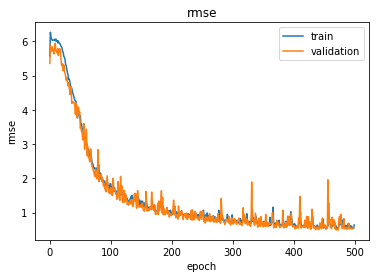

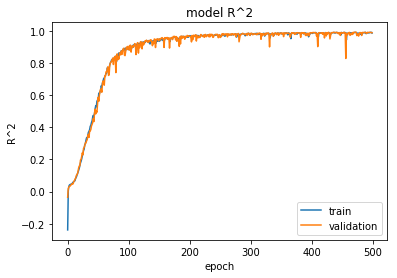

Mean absolute error (MAE):      0.562796
Mean squared error (MSE):       0.895155
Root mean squared error (RMSE): 0.946126
R square (R^2):                 0.989392


In [8]:
# Build model with 10000 samples
model1, MAE1, MSE1, RMSE1, R_2_1 = model(df, 10000, 500)

In [17]:
model1.save('model10000.h5')

## Build model with 20000 samples

Train on 16000 samples, validate on 4000 samples
Epoch 1/500
16000/16000 [==============================] - 0s 18us/step - loss: 114.2541 - rmse: 6.0384 - r_square: -0.1363 - val_loss: 103.2547 - val_rmse: 6.4354 - val_r_square: 0.0122
Epoch 2/500
16000/16000 [==============================] - 0s 5us/step - loss: 97.3256 - rmse: 6.2341 - r_square: 0.0342 - val_loss: 100.0656 - val_rmse: 6.3977 - val_r_square: 0.0393
Epoch 3/500
16000/16000 [==============================] - 0s 5us/step - loss: 96.1135 - rmse: 6.2006 - r_square: 0.0467 - val_loss: 100.4067 - val_rmse: 6.0824 - val_r_square: 0.0390
Epoch 4/500
16000/16000 [==============================] - 0s 5us/step - loss: 95.6872 - rmse: 6.1615 - r_square: 0.0511 - val_loss: 99.2958 - val_rmse: 6.1486 - val_r_square: 0.0481
Epoch 5/500
16000/16000 [==============================] - 0s 5us/step - loss: 94.9666 - rmse: 6.1571 - r_square: 0.0580 - val_loss: 98.2865 - val_rmse: 6.2341 - val_r_square: 0.0572
Epoch 6/500
16000/16000 [=====

16000/16000 [==============================] - 0s 5us/step - loss: 17.9896 - rmse: 2.6008 - r_square: 0.8154 - val_loss: 17.4756 - val_rmse: 2.8056 - val_r_square: 0.8295
Epoch 46/500
16000/16000 [==============================] - 0s 5us/step - loss: 16.1605 - rmse: 2.4457 - r_square: 0.8346 - val_loss: 16.1552 - val_rmse: 2.4135 - val_r_square: 0.8425
Epoch 47/500
16000/16000 [==============================] - 0s 5us/step - loss: 15.9370 - rmse: 2.4297 - r_square: 0.8362 - val_loss: 15.3038 - val_rmse: 2.5017 - val_r_square: 0.8507
Epoch 48/500
16000/16000 [==============================] - 0s 5us/step - loss: 15.1259 - rmse: 2.3688 - r_square: 0.8461 - val_loss: 14.5664 - val_rmse: 2.3157 - val_r_square: 0.8579
Epoch 49/500
16000/16000 [==============================] - 0s 5us/step - loss: 14.6700 - rmse: 2.3310 - r_square: 0.8490 - val_loss: 16.5709 - val_rmse: 2.4144 - val_r_square: 0.8394
Epoch 50/500
16000/16000 [==============================] - 0s 5us/step - loss: 13.1959 - rms

Epoch 90/500
16000/16000 [==============================] - 0s 6us/step - loss: 4.7928 - rmse: 1.2394 - r_square: 0.9516 - val_loss: 5.9156 - val_rmse: 1.4127 - val_r_square: 0.9432
Epoch 91/500
16000/16000 [==============================] - 0s 6us/step - loss: 4.3278 - rmse: 1.1796 - r_square: 0.9559 - val_loss: 4.5636 - val_rmse: 1.1931 - val_r_square: 0.9563
Epoch 92/500
16000/16000 [==============================] - 0s 5us/step - loss: 4.9258 - rmse: 1.2552 - r_square: 0.9493 - val_loss: 4.0083 - val_rmse: 1.1557 - val_r_square: 0.9612
Epoch 93/500
16000/16000 [==============================] - 0s 5us/step - loss: 4.0379 - rmse: 1.1357 - r_square: 0.9584 - val_loss: 3.7492 - val_rmse: 1.1489 - val_r_square: 0.9637
Epoch 94/500
16000/16000 [==============================] - 0s 5us/step - loss: 4.3620 - rmse: 1.2013 - r_square: 0.9548 - val_loss: 3.6656 - val_rmse: 1.0989 - val_r_square: 0.9642
Epoch 95/500
16000/16000 [==============================] - 0s 5us/step - loss: 4.5968 - r

Epoch 135/500
16000/16000 [==============================] - 0s 5us/step - loss: 2.6506 - rmse: 0.9197 - r_square: 0.9730 - val_loss: 2.0577 - val_rmse: 0.8354 - val_r_square: 0.9798
Epoch 136/500
16000/16000 [==============================] - 0s 5us/step - loss: 2.0149 - rmse: 0.8231 - r_square: 0.9793 - val_loss: 2.0049 - val_rmse: 0.8379 - val_r_square: 0.9803
Epoch 137/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.9523 - rmse: 0.8038 - r_square: 0.9801 - val_loss: 2.3665 - val_rmse: 0.8728 - val_r_square: 0.9770
Epoch 138/500
16000/16000 [==============================] - 0s 5us/step - loss: 2.2949 - rmse: 0.8705 - r_square: 0.9759 - val_loss: 1.8237 - val_rmse: 0.7981 - val_r_square: 0.9822
Epoch 139/500
16000/16000 [==============================] - 0s 5us/step - loss: 2.3901 - rmse: 0.8777 - r_square: 0.9754 - val_loss: 2.5290 - val_rmse: 0.9231 - val_r_square: 0.9751
Epoch 140/500
16000/16000 [==============================] - 0s 5us/step - loss: 2.25

Epoch 180/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.6042 - rmse: 0.7251 - r_square: 0.9839 - val_loss: 1.2301 - val_rmse: 0.7000 - val_r_square: 0.9879
Epoch 181/500
16000/16000 [==============================] - 0s 5us/step - loss: 2.2363 - rmse: 0.8177 - r_square: 0.9778 - val_loss: 1.2700 - val_rmse: 0.6671 - val_r_square: 0.9875
Epoch 182/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.3557 - rmse: 0.6810 - r_square: 0.9860 - val_loss: 1.1718 - val_rmse: 0.6462 - val_r_square: 0.9884
Epoch 183/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.3163 - rmse: 0.6710 - r_square: 0.9864 - val_loss: 1.1847 - val_rmse: 0.6756 - val_r_square: 0.9884
Epoch 184/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.2817 - rmse: 0.6545 - r_square: 0.9871 - val_loss: 1.1294 - val_rmse: 0.6563 - val_r_square: 0.9888
Epoch 185/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.35

Epoch 225/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.9308 - rmse: 0.5656 - r_square: 0.9905 - val_loss: 1.2238 - val_rmse: 0.6557 - val_r_square: 0.9880
Epoch 226/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.0417 - rmse: 0.5878 - r_square: 0.9893 - val_loss: 0.9288 - val_rmse: 0.5603 - val_r_square: 0.9908
Epoch 227/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.4591 - rmse: 0.6916 - r_square: 0.9853 - val_loss: 0.9973 - val_rmse: 0.6075 - val_r_square: 0.9900
Epoch 228/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.8507 - rmse: 0.5461 - r_square: 0.9912 - val_loss: 0.8084 - val_rmse: 0.5356 - val_r_square: 0.9920
Epoch 229/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.6043 - rmse: 0.6973 - r_square: 0.9837 - val_loss: 1.5053 - val_rmse: 0.7492 - val_r_square: 0.9852
Epoch 230/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.98

Epoch 270/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.6751 - rmse: 0.4857 - r_square: 0.9930 - val_loss: 0.6293 - val_rmse: 0.4752 - val_r_square: 0.9937
Epoch 271/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.8735 - rmse: 0.5345 - r_square: 0.9909 - val_loss: 0.6464 - val_rmse: 0.4811 - val_r_square: 0.9936
Epoch 272/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.8176 - rmse: 0.5232 - r_square: 0.9915 - val_loss: 0.6756 - val_rmse: 0.4936 - val_r_square: 0.9933
Epoch 273/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.9510 - rmse: 0.5600 - r_square: 0.9904 - val_loss: 0.6843 - val_rmse: 0.4895 - val_r_square: 0.9933
Epoch 274/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.0371 - rmse: 0.5836 - r_square: 0.9891 - val_loss: 0.7455 - val_rmse: 0.5309 - val_r_square: 0.9926
Epoch 275/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.13

Epoch 315/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.8437 - rmse: 0.5232 - r_square: 0.9914 - val_loss: 1.2680 - val_rmse: 0.7016 - val_r_square: 0.9873
Epoch 316/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.1573 - rmse: 0.6101 - r_square: 0.9882 - val_loss: 0.7535 - val_rmse: 0.5067 - val_r_square: 0.9926
Epoch 317/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.0058 - rmse: 0.5703 - r_square: 0.9894 - val_loss: 0.6324 - val_rmse: 0.4824 - val_r_square: 0.9937
Epoch 318/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.8232 - rmse: 0.5158 - r_square: 0.9915 - val_loss: 0.6839 - val_rmse: 0.4899 - val_r_square: 0.9932
Epoch 319/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.9661 - rmse: 0.5590 - r_square: 0.9900 - val_loss: 0.7924 - val_rmse: 0.5538 - val_r_square: 0.9921
Epoch 320/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.11

Epoch 360/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.7791 - rmse: 0.4979 - r_square: 0.9922 - val_loss: 0.5435 - val_rmse: 0.4363 - val_r_square: 0.9947
Epoch 361/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.6863 - rmse: 0.4840 - r_square: 0.9929 - val_loss: 0.5427 - val_rmse: 0.4446 - val_r_square: 0.9946
Epoch 362/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.5964 - rmse: 0.4561 - r_square: 0.9939 - val_loss: 0.7136 - val_rmse: 0.4768 - val_r_square: 0.9929
Epoch 363/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.8825 - rmse: 0.5321 - r_square: 0.9906 - val_loss: 0.7951 - val_rmse: 0.4816 - val_r_square: 0.9923
Epoch 364/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.3790 - rmse: 0.6366 - r_square: 0.9855 - val_loss: 0.8227 - val_rmse: 0.5655 - val_r_square: 0.9918
Epoch 365/500
16000/16000 [==============================] - 0s 5us/step - loss: 1.11

Epoch 405/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.6179 - rmse: 0.4597 - r_square: 0.9936 - val_loss: 0.5853 - val_rmse: 0.4790 - val_r_square: 0.9942
Epoch 406/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.6819 - rmse: 0.4764 - r_square: 0.9929 - val_loss: 0.4825 - val_rmse: 0.4042 - val_r_square: 0.9953
Epoch 407/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.5950 - rmse: 0.4459 - r_square: 0.9939 - val_loss: 0.4676 - val_rmse: 0.4086 - val_r_square: 0.9954
Epoch 408/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.6758 - rmse: 0.4748 - r_square: 0.9928 - val_loss: 0.8450 - val_rmse: 0.5340 - val_r_square: 0.9917
Epoch 409/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.6235 - rmse: 0.4564 - r_square: 0.9936 - val_loss: 0.8823 - val_rmse: 0.4987 - val_r_square: 0.9913
Epoch 410/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.77

Epoch 450/500
16000/16000 [==============================] - 0s 6us/step - loss: 0.7566 - rmse: 0.4963 - r_square: 0.9922 - val_loss: 1.4320 - val_rmse: 0.6629 - val_r_square: 0.9860
Epoch 451/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.5594 - rmse: 0.4379 - r_square: 0.9941 - val_loss: 0.5217 - val_rmse: 0.4270 - val_r_square: 0.9949
Epoch 452/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.5801 - rmse: 0.4387 - r_square: 0.9938 - val_loss: 0.4545 - val_rmse: 0.4204 - val_r_square: 0.9955
Epoch 453/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.5019 - rmse: 0.4169 - r_square: 0.9948 - val_loss: 0.5087 - val_rmse: 0.4130 - val_r_square: 0.9950
Epoch 454/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.5303 - rmse: 0.4261 - r_square: 0.9945 - val_loss: 0.4483 - val_rmse: 0.3990 - val_r_square: 0.9956
Epoch 455/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.58

Epoch 495/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.6100 - rmse: 0.4485 - r_square: 0.9936 - val_loss: 0.6656 - val_rmse: 0.4624 - val_r_square: 0.9935
Epoch 496/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.5712 - rmse: 0.4378 - r_square: 0.9940 - val_loss: 0.4247 - val_rmse: 0.3929 - val_r_square: 0.9958
Epoch 497/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.6053 - rmse: 0.4407 - r_square: 0.9936 - val_loss: 0.8294 - val_rmse: 0.5135 - val_r_square: 0.9918
Epoch 498/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.5041 - rmse: 0.4104 - r_square: 0.9949 - val_loss: 0.5613 - val_rmse: 0.4059 - val_r_square: 0.9945
Epoch 499/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.6059 - rmse: 0.4428 - r_square: 0.9938 - val_loss: 0.4178 - val_rmse: 0.3898 - val_r_square: 0.9959
Epoch 500/500
16000/16000 [==============================] - 0s 5us/step - loss: 0.77

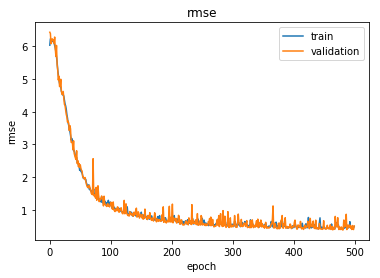

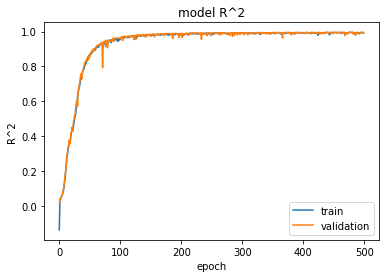

Mean absolute error (MAE):      0.501796
Mean squared error (MSE):       0.910837
Root mean squared error (RMSE): 0.954378
R square (R^2):                 0.991322


In [9]:
# Build with 20000 samples
model2, MAE2, MSE2, RMSE2, R_2_2 = model(df, 20000, 500)

In [19]:
model2.save('model20000.h5')

## Build model with 30000 samples

Train on 24000 samples, validate on 6000 samples
Epoch 1/500
24000/24000 [==============================] - 0s 15us/step - loss: 99.0750 - rmse: 5.9842 - r_square: -0.0660 - val_loss: 88.5182 - val_rmse: 6.1026 - val_r_square: 0.0422
Epoch 2/500
24000/24000 [==============================] - 0s 6us/step - loss: 88.7825 - rmse: 6.0387 - r_square: 0.0443 - val_loss: 87.2123 - val_rmse: 6.0213 - val_r_square: 0.0559
Epoch 3/500
24000/24000 [==============================] - 0s 5us/step - loss: 87.7398 - rmse: 6.0202 - r_square: 0.0565 - val_loss: 86.3529 - val_rmse: 6.2036 - val_r_square: 0.0620
Epoch 4/500
24000/24000 [==============================] - 0s 5us/step - loss: 86.5204 - rmse: 5.9913 - r_square: 0.0666 - val_loss: 84.7770 - val_rmse: 5.8126 - val_r_square: 0.0811
Epoch 5/500
24000/24000 [==============================] - 0s 5us/step - loss: 84.4183 - rmse: 5.9431 - r_square: 0.0903 - val_loss: 81.7965 - val_rmse: 5.8199 - val_r_square: 0.1100
Epoch 6/500
24000/24000 [=========

24000/24000 [==============================] - 0s 5us/step - loss: 5.3196 - rmse: 1.3624 - r_square: 0.9409 - val_loss: 6.3978 - val_rmse: 1.4788 - val_r_square: 0.9273
Epoch 46/500
24000/24000 [==============================] - 0s 5us/step - loss: 4.8360 - rmse: 1.2939 - r_square: 0.9463 - val_loss: 4.8822 - val_rmse: 1.2380 - val_r_square: 0.9455
Epoch 47/500
24000/24000 [==============================] - 0s 6us/step - loss: 5.1749 - rmse: 1.3350 - r_square: 0.9426 - val_loss: 4.6640 - val_rmse: 1.2749 - val_r_square: 0.9471
Epoch 48/500
24000/24000 [==============================] - 0s 5us/step - loss: 5.1388 - rmse: 1.3256 - r_square: 0.9426 - val_loss: 4.7928 - val_rmse: 1.2321 - val_r_square: 0.9468
Epoch 49/500
24000/24000 [==============================] - 0s 5us/step - loss: 4.6630 - rmse: 1.2663 - r_square: 0.9480 - val_loss: 4.4135 - val_rmse: 1.2356 - val_r_square: 0.9504
Epoch 50/500
24000/24000 [==============================] - 0s 5us/step - loss: 4.3443 - rmse: 1.2368 -

24000/24000 [==============================] - 0s 5us/step - loss: 1.8927 - rmse: 0.8121 - r_square: 0.9788 - val_loss: 1.9084 - val_rmse: 0.7829 - val_r_square: 0.9788
Epoch 91/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.8135 - rmse: 0.7952 - r_square: 0.9798 - val_loss: 1.7595 - val_rmse: 0.7677 - val_r_square: 0.9802
Epoch 92/500
24000/24000 [==============================] - 0s 6us/step - loss: 2.3431 - rmse: 0.8578 - r_square: 0.9747 - val_loss: 8.1034 - val_rmse: 1.5005 - val_r_square: 0.9113
Epoch 93/500
24000/24000 [==============================] - 0s 5us/step - loss: 2.4019 - rmse: 0.8698 - r_square: 0.9726 - val_loss: 1.5838 - val_rmse: 0.7389 - val_r_square: 0.9823
Epoch 94/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.7027 - rmse: 0.7768 - r_square: 0.9810 - val_loss: 1.7272 - val_rmse: 0.7736 - val_r_square: 0.9804
Epoch 95/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.9329 - rmse: 0.8080 -

Epoch 135/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.2013 - rmse: 0.6323 - r_square: 0.9866 - val_loss: 1.5121 - val_rmse: 0.6862 - val_r_square: 0.9832
Epoch 136/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.0339 - rmse: 0.5971 - r_square: 0.9883 - val_loss: 1.4225 - val_rmse: 0.6606 - val_r_square: 0.9844
Epoch 137/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.9948 - rmse: 0.5870 - r_square: 0.9888 - val_loss: 1.0961 - val_rmse: 0.5847 - val_r_square: 0.9879
Epoch 138/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.3261 - rmse: 0.6647 - r_square: 0.9851 - val_loss: 1.3845 - val_rmse: 0.6710 - val_r_square: 0.9847
Epoch 139/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.1769 - rmse: 0.6408 - r_square: 0.9867 - val_loss: 1.6038 - val_rmse: 0.6821 - val_r_square: 0.9823
Epoch 140/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.27

Epoch 180/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.3258 - rmse: 0.6368 - r_square: 0.9859 - val_loss: 0.8902 - val_rmse: 0.5271 - val_r_square: 0.9902
Epoch 181/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.8536 - rmse: 0.5348 - r_square: 0.9904 - val_loss: 0.8191 - val_rmse: 0.5174 - val_r_square: 0.9909
Epoch 182/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.8748 - rmse: 0.5430 - r_square: 0.9902 - val_loss: 1.7623 - val_rmse: 0.7165 - val_r_square: 0.9807
Epoch 183/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.9556 - rmse: 0.5610 - r_square: 0.9893 - val_loss: 1.0535 - val_rmse: 0.5745 - val_r_square: 0.9883
Epoch 184/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.2249 - rmse: 0.6281 - r_square: 0.9863 - val_loss: 1.3165 - val_rmse: 0.6679 - val_r_square: 0.9851
Epoch 185/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.90

Epoch 225/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.9568 - rmse: 0.5477 - r_square: 0.9892 - val_loss: 0.9108 - val_rmse: 0.5258 - val_r_square: 0.9896
Epoch 226/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.6689 - rmse: 0.6678 - r_square: 0.9816 - val_loss: 1.1254 - val_rmse: 0.5938 - val_r_square: 0.9872
Epoch 227/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.7134 - rmse: 0.4854 - r_square: 0.9920 - val_loss: 1.4507 - val_rmse: 0.6588 - val_r_square: 0.9839
Epoch 228/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.7550 - rmse: 0.5004 - r_square: 0.9915 - val_loss: 1.7163 - val_rmse: 0.8059 - val_r_square: 0.9804
Epoch 229/500
24000/24000 [==============================] - 0s 6us/step - loss: 1.1190 - rmse: 0.6017 - r_square: 0.9871 - val_loss: 0.6043 - val_rmse: 0.4468 - val_r_square: 0.9932
Epoch 230/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.69

Epoch 270/500
24000/24000 [==============================] - 0s 6us/step - loss: 0.5707 - rmse: 0.4438 - r_square: 0.9935 - val_loss: 0.5211 - val_rmse: 0.4174 - val_r_square: 0.9941
Epoch 271/500
24000/24000 [==============================] - 0s 6us/step - loss: 0.9386 - rmse: 0.5396 - r_square: 0.9894 - val_loss: 0.5845 - val_rmse: 0.4550 - val_r_square: 0.9934
Epoch 272/500
24000/24000 [==============================] - 0s 6us/step - loss: 0.8965 - rmse: 0.5291 - r_square: 0.9901 - val_loss: 0.6832 - val_rmse: 0.4602 - val_r_square: 0.9923
Epoch 273/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.6343 - rmse: 0.4583 - r_square: 0.9930 - val_loss: 0.5914 - val_rmse: 0.4457 - val_r_square: 0.9933
Epoch 274/500
24000/24000 [==============================] - 0s 6us/step - loss: 0.6689 - rmse: 0.4821 - r_square: 0.9924 - val_loss: 1.6068 - val_rmse: 0.6338 - val_r_square: 0.9817
Epoch 275/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.22

Epoch 315/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.8053 - rmse: 0.5039 - r_square: 0.9911 - val_loss: 1.0559 - val_rmse: 0.5680 - val_r_square: 0.9879
Epoch 316/500
24000/24000 [==============================] - 0s 6us/step - loss: 0.5917 - rmse: 0.4512 - r_square: 0.9934 - val_loss: 0.5799 - val_rmse: 0.4533 - val_r_square: 0.9934
Epoch 317/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.7129 - rmse: 0.4804 - r_square: 0.9919 - val_loss: 0.5608 - val_rmse: 0.4273 - val_r_square: 0.9937
Epoch 318/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.6892 - rmse: 0.4764 - r_square: 0.9923 - val_loss: 0.5506 - val_rmse: 0.4386 - val_r_square: 0.9938
Epoch 319/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.8198 - rmse: 0.5091 - r_square: 0.9907 - val_loss: 1.0296 - val_rmse: 0.6018 - val_r_square: 0.9885
Epoch 320/500
24000/24000 [==============================] - 0s 5us/step - loss: 1.09

Epoch 360/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.5690 - rmse: 0.4341 - r_square: 0.9936 - val_loss: 0.9313 - val_rmse: 0.5086 - val_r_square: 0.9896
Epoch 361/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.7544 - rmse: 0.4820 - r_square: 0.9915 - val_loss: 0.5641 - val_rmse: 0.4180 - val_r_square: 0.9935
Epoch 362/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.6339 - rmse: 0.4497 - r_square: 0.9930 - val_loss: 3.6507 - val_rmse: 1.0181 - val_r_square: 0.9598
Epoch 363/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.7208 - rmse: 0.4633 - r_square: 0.9920 - val_loss: 0.5247 - val_rmse: 0.4212 - val_r_square: 0.9940
Epoch 364/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.5682 - rmse: 0.4358 - r_square: 0.9936 - val_loss: 0.5378 - val_rmse: 0.4036 - val_r_square: 0.9938
Epoch 365/500
24000/24000 [==============================] - 0s 5us/step - loss: 0.63

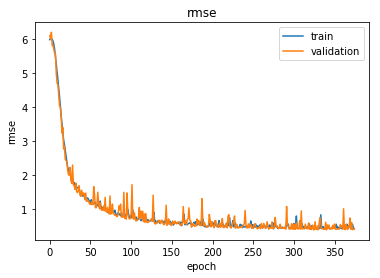

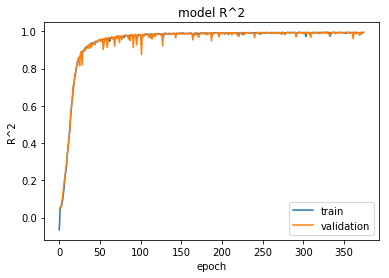

Mean absolute error (MAE):      0.419812
Mean squared error (MSE):       0.500122
Root mean squared error (RMSE): 0.707193
R square (R^2):                 0.994604


In [11]:
# Build with 30000 samples
model3, MAE3, MSE3, RMSE3, R_2_3 = model(df, 30000, 500)

In [23]:
model3.save('model30000.h5')

## Build model with 40000 samples

Train on 32000 samples, validate on 8000 samples
Epoch 1/500
32000/32000 [==============================] - 0s 14us/step - loss: 99.0692 - rmse: 6.0641 - r_square: -0.0489 - val_loss: 92.6017 - val_rmse: 6.0398 - val_r_square: 0.0418
Epoch 2/500
32000/32000 [==============================] - 0s 5us/step - loss: 90.5398 - rmse: 6.0921 - r_square: 0.0448 - val_loss: 91.8199 - val_rmse: 6.0542 - val_r_square: 0.0498
Epoch 3/500
32000/32000 [==============================] - 0s 5us/step - loss: 89.9209 - rmse: 6.0883 - r_square: 0.0517 - val_loss: 90.9402 - val_rmse: 6.0653 - val_r_square: 0.0584
Epoch 4/500
32000/32000 [==============================] - 0s 6us/step - loss: 88.8909 - rmse: 6.0844 - r_square: 0.0625 - val_loss: 89.7115 - val_rmse: 5.9529 - val_r_square: 0.0709
Epoch 5/500
32000/32000 [==============================] - 0s 5us/step - loss: 87.1463 - rmse: 6.0566 - r_square: 0.0790 - val_loss: 86.8309 - val_rmse: 5.8864 - val_r_square: 0.1001
Epoch 6/500
32000/32000 [=========

32000/32000 [==============================] - 0s 5us/step - loss: 4.2640 - rmse: 1.1604 - r_square: 0.9541 - val_loss: 3.6931 - val_rmse: 1.0438 - val_r_square: 0.9609
Epoch 46/500
32000/32000 [==============================] - 0s 5us/step - loss: 3.7901 - rmse: 1.0745 - r_square: 0.9590 - val_loss: 3.1778 - val_rmse: 1.0183 - val_r_square: 0.9664
Epoch 47/500
32000/32000 [==============================] - 0s 5us/step - loss: 3.7154 - rmse: 1.0730 - r_square: 0.9599 - val_loss: 4.5977 - val_rmse: 1.3375 - val_r_square: 0.9513
Epoch 48/500
32000/32000 [==============================] - 0s 6us/step - loss: 3.7208 - rmse: 1.0716 - r_square: 0.9594 - val_loss: 4.1186 - val_rmse: 1.1319 - val_r_square: 0.9563
Epoch 49/500
32000/32000 [==============================] - 0s 6us/step - loss: 3.2372 - rmse: 1.0037 - r_square: 0.9642 - val_loss: 3.2907 - val_rmse: 1.0095 - val_r_square: 0.9653
Epoch 50/500
32000/32000 [==============================] - 0s 5us/step - loss: 3.5175 - rmse: 1.0424 -

32000/32000 [==============================] - 0s 6us/step - loss: 1.4358 - rmse: 0.6771 - r_square: 0.9844 - val_loss: 1.6565 - val_rmse: 0.7186 - val_r_square: 0.9824
Epoch 91/500
32000/32000 [==============================] - 0s 6us/step - loss: 1.6050 - rmse: 0.7229 - r_square: 0.9822 - val_loss: 1.9205 - val_rmse: 0.7673 - val_r_square: 0.9796
Epoch 92/500
32000/32000 [==============================] - 0s 6us/step - loss: 3.3668 - rmse: 0.9367 - r_square: 0.9636 - val_loss: 7.8609 - val_rmse: 1.5041 - val_r_square: 0.9166
Epoch 93/500
32000/32000 [==============================] - 0s 5us/step - loss: 2.2737 - rmse: 0.8354 - r_square: 0.9755 - val_loss: 1.2686 - val_rmse: 0.6418 - val_r_square: 0.9865
Epoch 94/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.4250 - rmse: 0.6769 - r_square: 0.9845 - val_loss: 2.0105 - val_rmse: 0.8412 - val_r_square: 0.9788
Epoch 95/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.3554 - rmse: 0.6611 -

Epoch 135/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.1148 - rmse: 0.5982 - r_square: 0.9878 - val_loss: 1.7376 - val_rmse: 0.8131 - val_r_square: 0.9815
Epoch 136/500
32000/32000 [==============================] - 0s 5us/step - loss: 2.5817 - rmse: 0.8709 - r_square: 0.9725 - val_loss: 1.0430 - val_rmse: 0.5885 - val_r_square: 0.9889
Epoch 137/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.3482 - rmse: 0.6451 - r_square: 0.9855 - val_loss: 0.8117 - val_rmse: 0.5246 - val_r_square: 0.9913
Epoch 138/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.0062 - rmse: 0.5813 - r_square: 0.9891 - val_loss: 1.1756 - val_rmse: 0.6207 - val_r_square: 0.9874
Epoch 139/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.1943 - rmse: 0.6198 - r_square: 0.9870 - val_loss: 2.5414 - val_rmse: 0.8815 - val_r_square: 0.9731
Epoch 140/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.05

Epoch 180/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.8875 - rmse: 0.5399 - r_square: 0.9904 - val_loss: 0.6993 - val_rmse: 0.4921 - val_r_square: 0.9925
Epoch 181/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.0728 - rmse: 0.5764 - r_square: 0.9881 - val_loss: 1.1934 - val_rmse: 0.6154 - val_r_square: 0.9873
Epoch 182/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.8813 - rmse: 0.5454 - r_square: 0.9904 - val_loss: 0.7285 - val_rmse: 0.5213 - val_r_square: 0.9922
Epoch 183/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.0364 - rmse: 0.5668 - r_square: 0.9890 - val_loss: 0.6655 - val_rmse: 0.5044 - val_r_square: 0.9928
Epoch 184/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.8915 - rmse: 0.5419 - r_square: 0.9903 - val_loss: 0.7365 - val_rmse: 0.5164 - val_r_square: 0.9921
Epoch 185/500
32000/32000 [==============================] - 0s 5us/step - loss: 1.84

Epoch 225/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.7185 - rmse: 0.4957 - r_square: 0.9918 - val_loss: 0.6439 - val_rmse: 0.4558 - val_r_square: 0.9931
Epoch 226/500
32000/32000 [==============================] - 0s 6us/step - loss: 0.8210 - rmse: 0.5159 - r_square: 0.9909 - val_loss: 0.5649 - val_rmse: 0.4363 - val_r_square: 0.9939
Epoch 227/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.7109 - rmse: 0.5003 - r_square: 0.9922 - val_loss: 0.6411 - val_rmse: 0.4933 - val_r_square: 0.9931
Epoch 228/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.7397 - rmse: 0.5026 - r_square: 0.9919 - val_loss: 0.8604 - val_rmse: 0.5689 - val_r_square: 0.9909
Epoch 229/500
32000/32000 [==============================] - 0s 6us/step - loss: 0.7200 - rmse: 0.4959 - r_square: 0.9921 - val_loss: 0.6964 - val_rmse: 0.4912 - val_r_square: 0.9925
Epoch 230/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.71

Epoch 270/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.6762 - rmse: 0.4823 - r_square: 0.9925 - val_loss: 0.5096 - val_rmse: 0.4314 - val_r_square: 0.9945
Epoch 271/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.9320 - rmse: 0.5552 - r_square: 0.9898 - val_loss: 0.5343 - val_rmse: 0.4262 - val_r_square: 0.9943
Epoch 272/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.6378 - rmse: 0.4655 - r_square: 0.9930 - val_loss: 0.7429 - val_rmse: 0.5374 - val_r_square: 0.9921
Epoch 273/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.7772 - rmse: 0.5104 - r_square: 0.9916 - val_loss: 1.7390 - val_rmse: 0.6802 - val_r_square: 0.9816
Epoch 274/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.6649 - rmse: 0.4848 - r_square: 0.9926 - val_loss: 0.7097 - val_rmse: 0.4700 - val_r_square: 0.9924
Epoch 275/500
32000/32000 [==============================] - 0s 5us/step - loss: 0.71

Epoch 00314: early stopping


Model prediction: [[10.382164  ]
 [ 2.4666164 ]
 [ 3.198968  ]
 [-0.02138168]
 [11.893993  ]
 [ 6.982744  ]
 [ 0.12605351]
 [ 3.7086713 ]
 [-0.12614948]
 [ 0.06579417]]
Actual value: [10.1   3.05  2.54  0.13 12.35  6.65  0.05  3.85  0.08  0.11]




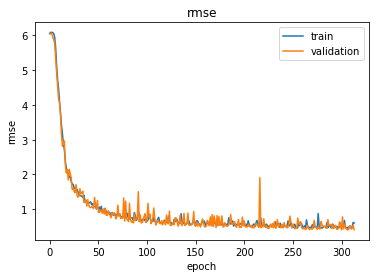

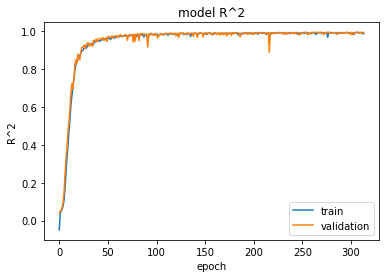

Mean absolute error (MAE):      0.407965
Mean squared error (MSE):       0.475459
Root mean squared error (RMSE): 0.689535
R square (R^2):                 0.995089


In [12]:
# Build with 40000 samples
model4, MAE4, MSE4, RMSE4, R_2_4 = model(df, 40000, 500)

In [24]:
model4.save('model40000.h5')

## Build model with 50000 samples

Train on 40000 samples, validate on 10000 samples
Epoch 1/500
40000/40000 [==============================] - 1s 14us/step - loss: 97.9433 - rmse: 6.0374 - r_square: -0.0334 - val_loss: 87.8256 - val_rmse: 5.9009 - val_r_square: 0.0343
Epoch 2/500
40000/40000 [==============================] - 0s 5us/step - loss: 90.7161 - rmse: 6.0542 - r_square: 0.0451 - val_loss: 86.9227 - val_rmse: 6.0118 - val_r_square: 0.0429
Epoch 3/500
40000/40000 [==============================] - 0s 5us/step - loss: 89.2699 - rmse: 6.0665 - r_square: 0.0596 - val_loss: 85.0876 - val_rmse: 6.0793 - val_r_square: 0.0606
Epoch 4/500
40000/40000 [==============================] - 0s 6us/step - loss: 86.1483 - rmse: 6.0099 - r_square: 0.0926 - val_loss: 80.5946 - val_rmse: 5.9429 - val_r_square: 0.1053
Epoch 5/500
40000/40000 [==============================] - 0s 5us/step - loss: 81.0591 - rmse: 5.8804 - r_square: 0.1388 - val_loss: 74.3889 - val_rmse: 5.6098 - val_r_square: 0.1691
Epoch 6/500
40000/40000 [========

40000/40000 [==============================] - 0s 5us/step - loss: 3.4077 - rmse: 1.0864 - r_square: 0.9626 - val_loss: 3.4286 - val_rmse: 1.0818 - val_r_square: 0.9609
Epoch 46/500
40000/40000 [==============================] - 0s 5us/step - loss: 3.0835 - rmse: 1.0485 - r_square: 0.9666 - val_loss: 2.4887 - val_rmse: 0.9590 - val_r_square: 0.9712
Epoch 47/500
40000/40000 [==============================] - 0s 5us/step - loss: 3.2032 - rmse: 1.0543 - r_square: 0.9652 - val_loss: 2.5192 - val_rmse: 0.9642 - val_r_square: 0.9709
Epoch 48/500
40000/40000 [==============================] - 0s 5us/step - loss: 2.9807 - rmse: 1.0279 - r_square: 0.9676 - val_loss: 2.8475 - val_rmse: 1.0036 - val_r_square: 0.9671
Epoch 49/500
40000/40000 [==============================] - 0s 5us/step - loss: 2.8325 - rmse: 0.9959 - r_square: 0.9691 - val_loss: 2.6611 - val_rmse: 1.0193 - val_r_square: 0.9691
Epoch 50/500
40000/40000 [==============================] - 0s 6us/step - loss: 2.8120 - rmse: 0.9920 -

40000/40000 [==============================] - 0s 5us/step - loss: 1.6012 - rmse: 0.7288 - r_square: 0.9824 - val_loss: 1.1589 - val_rmse: 0.6465 - val_r_square: 0.9865
Epoch 91/500
40000/40000 [==============================] - 0s 5us/step - loss: 1.3768 - rmse: 0.6887 - r_square: 0.9850 - val_loss: 1.0869 - val_rmse: 0.6462 - val_r_square: 0.9872
Epoch 92/500
40000/40000 [==============================] - 0s 5us/step - loss: 1.6677 - rmse: 0.7415 - r_square: 0.9816 - val_loss: 1.0879 - val_rmse: 0.6360 - val_r_square: 0.9872
Epoch 93/500
40000/40000 [==============================] - 0s 5us/step - loss: 1.2815 - rmse: 0.6678 - r_square: 0.9859 - val_loss: 1.1117 - val_rmse: 0.6286 - val_r_square: 0.9869
Epoch 94/500
40000/40000 [==============================] - 0s 5us/step - loss: 1.3948 - rmse: 0.6897 - r_square: 0.9847 - val_loss: 3.6811 - val_rmse: 1.0443 - val_r_square: 0.9585
Epoch 95/500
40000/40000 [==============================] - 0s 5us/step - loss: 1.4887 - rmse: 0.6960 -

Epoch 135/500
40000/40000 [==============================] - 0s 6us/step - loss: 0.9498 - rmse: 0.5741 - r_square: 0.9895 - val_loss: 1.9093 - val_rmse: 0.7224 - val_r_square: 0.9778
Epoch 136/500
40000/40000 [==============================] - 0s 6us/step - loss: 1.0291 - rmse: 0.5897 - r_square: 0.9887 - val_loss: 1.0138 - val_rmse: 0.5632 - val_r_square: 0.9884
Epoch 137/500
40000/40000 [==============================] - 0s 6us/step - loss: 0.8673 - rmse: 0.5529 - r_square: 0.9906 - val_loss: 1.1521 - val_rmse: 0.6271 - val_r_square: 0.9868
Epoch 138/500
40000/40000 [==============================] - 0s 6us/step - loss: 0.8605 - rmse: 0.5521 - r_square: 0.9906 - val_loss: 1.7983 - val_rmse: 0.7431 - val_r_square: 0.9796
Epoch 139/500
40000/40000 [==============================] - 0s 6us/step - loss: 1.4327 - rmse: 0.6587 - r_square: 0.9847 - val_loss: 0.8417 - val_rmse: 0.5431 - val_r_square: 0.9902
Epoch 140/500
40000/40000 [==============================] - 0s 6us/step - loss: 0.86

Epoch 180/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.7320 - rmse: 0.5047 - r_square: 0.9919 - val_loss: 0.6876 - val_rmse: 0.4881 - val_r_square: 0.9920
Epoch 181/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.7989 - rmse: 0.5176 - r_square: 0.9913 - val_loss: 0.9174 - val_rmse: 0.5210 - val_r_square: 0.9894
Epoch 182/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.6553 - rmse: 0.4802 - r_square: 0.9928 - val_loss: 0.5607 - val_rmse: 0.4626 - val_r_square: 0.9934
Epoch 183/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.7519 - rmse: 0.5086 - r_square: 0.9918 - val_loss: 0.9104 - val_rmse: 0.5320 - val_r_square: 0.9896
Epoch 184/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.6569 - rmse: 0.4840 - r_square: 0.9928 - val_loss: 0.7913 - val_rmse: 0.5186 - val_r_square: 0.9910
Epoch 185/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.70

Epoch 225/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.6189 - rmse: 0.4672 - r_square: 0.9932 - val_loss: 0.5418 - val_rmse: 0.4524 - val_r_square: 0.9937
Epoch 226/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.6704 - rmse: 0.4686 - r_square: 0.9927 - val_loss: 1.1053 - val_rmse: 0.5723 - val_r_square: 0.9871
Epoch 227/500
40000/40000 [==============================] - 0s 5us/step - loss: 1.3083 - rmse: 0.6194 - r_square: 0.9859 - val_loss: 0.7543 - val_rmse: 0.5128 - val_r_square: 0.9913
Epoch 228/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.6344 - rmse: 0.4670 - r_square: 0.9930 - val_loss: 0.8563 - val_rmse: 0.5229 - val_r_square: 0.9902
Epoch 229/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.8876 - rmse: 0.5236 - r_square: 0.9905 - val_loss: 1.4993 - val_rmse: 0.6090 - val_r_square: 0.9830
Epoch 230/500
40000/40000 [==============================] - 0s 5us/step - loss: 1.03

Epoch 270/500
40000/40000 [==============================] - 0s 6us/step - loss: 0.5379 - rmse: 0.4343 - r_square: 0.9941 - val_loss: 0.5166 - val_rmse: 0.4529 - val_r_square: 0.9940
Epoch 271/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.5087 - rmse: 0.4263 - r_square: 0.9944 - val_loss: 0.5616 - val_rmse: 0.4316 - val_r_square: 0.9936
Epoch 272/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.7007 - rmse: 0.4710 - r_square: 0.9923 - val_loss: 0.4673 - val_rmse: 0.3953 - val_r_square: 0.9946
Epoch 273/500
40000/40000 [==============================] - 0s 6us/step - loss: 0.6362 - rmse: 0.4623 - r_square: 0.9931 - val_loss: 1.1736 - val_rmse: 0.6618 - val_r_square: 0.9865
Epoch 274/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.5200 - rmse: 0.4267 - r_square: 0.9943 - val_loss: 0.5186 - val_rmse: 0.4272 - val_r_square: 0.9939
Epoch 275/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.63

Epoch 315/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.6024 - rmse: 0.4519 - r_square: 0.9934 - val_loss: 0.5171 - val_rmse: 0.4278 - val_r_square: 0.9940
Epoch 316/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.7503 - rmse: 0.4799 - r_square: 0.9917 - val_loss: 0.4216 - val_rmse: 0.3709 - val_r_square: 0.9951
Epoch 317/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.5260 - rmse: 0.4255 - r_square: 0.9943 - val_loss: 0.5534 - val_rmse: 0.4490 - val_r_square: 0.9936
Epoch 318/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.5243 - rmse: 0.4243 - r_square: 0.9943 - val_loss: 0.4516 - val_rmse: 0.4022 - val_r_square: 0.9947
Epoch 319/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.6915 - rmse: 0.4740 - r_square: 0.9926 - val_loss: 0.5910 - val_rmse: 0.4223 - val_r_square: 0.9932
Epoch 320/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.52

Epoch 360/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.6526 - rmse: 0.4568 - r_square: 0.9928 - val_loss: 0.7417 - val_rmse: 0.5269 - val_r_square: 0.9915
Epoch 361/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.6262 - rmse: 0.4510 - r_square: 0.9931 - val_loss: 0.4131 - val_rmse: 0.3815 - val_r_square: 0.9952
Epoch 362/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.5610 - rmse: 0.4294 - r_square: 0.9938 - val_loss: 0.3904 - val_rmse: 0.3636 - val_r_square: 0.9955
Epoch 363/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.4656 - rmse: 0.3964 - r_square: 0.9950 - val_loss: 0.5034 - val_rmse: 0.4238 - val_r_square: 0.9942
Epoch 364/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.4584 - rmse: 0.3966 - r_square: 0.9950 - val_loss: 0.5633 - val_rmse: 0.4675 - val_r_square: 0.9935
Epoch 365/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.55

Epoch 405/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.5091 - rmse: 0.4061 - r_square: 0.9944 - val_loss: 0.4111 - val_rmse: 0.3680 - val_r_square: 0.9953
Epoch 406/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.4557 - rmse: 0.3897 - r_square: 0.9950 - val_loss: 1.6896 - val_rmse: 0.6854 - val_r_square: 0.9810
Epoch 407/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.7161 - rmse: 0.4723 - r_square: 0.9922 - val_loss: 0.3678 - val_rmse: 0.3481 - val_r_square: 0.9957
Epoch 408/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.4953 - rmse: 0.4055 - r_square: 0.9946 - val_loss: 0.3601 - val_rmse: 0.3522 - val_r_square: 0.9958
Epoch 409/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.5695 - rmse: 0.4281 - r_square: 0.9937 - val_loss: 0.4848 - val_rmse: 0.4412 - val_r_square: 0.9943
Epoch 410/500
40000/40000 [==============================] - 0s 5us/step - loss: 0.55

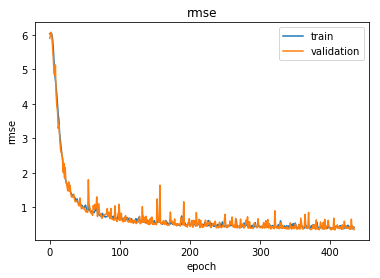

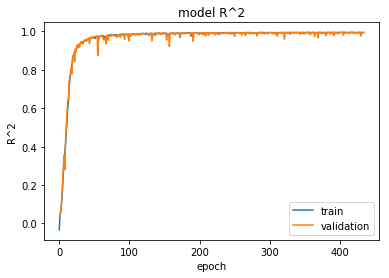

Mean absolute error (MAE):      0.356490
Mean squared error (MSE):       0.366645
Root mean squared error (RMSE): 0.605512
R square (R^2):                 0.995974


In [13]:
# Build with 50000 samples
model5, MAE5, MSE5, RMSE5, R_2_5 = model(df, 50000, 500)

In [25]:
model5.save('model50000.h5')

## Build model with 60000 samples

Train on 48000 samples, validate on 12000 samples
Epoch 1/500
48000/48000 [==============================] - 1s 13us/step - loss: 99.3044 - rmse: 6.0893 - r_square: -0.0214 - val_loss: 93.5983 - val_rmse: 6.3275 - val_r_square: 0.0314
Epoch 2/500
48000/48000 [==============================] - 0s 5us/step - loss: 92.2625 - rmse: 6.1022 - r_square: 0.0523 - val_loss: 91.5172 - val_rmse: 6.2242 - val_r_square: 0.0540
Epoch 3/500
48000/48000 [==============================] - 0s 5us/step - loss: 89.8854 - rmse: 6.0890 - r_square: 0.0745 - val_loss: 87.8177 - val_rmse: 5.9771 - val_r_square: 0.0908
Epoch 4/500
48000/48000 [==============================] - 0s 5us/step - loss: 84.0244 - rmse: 5.9250 - r_square: 0.1320 - val_loss: 78.8764 - val_rmse: 5.9642 - val_r_square: 0.1746
Epoch 5/500
48000/48000 [==============================] - 0s 5us/step - loss: 74.0456 - rmse: 5.4793 - r_square: 0.2293 - val_loss: 67.7918 - val_rmse: 5.0085 - val_r_square: 0.2920
Epoch 6/500
48000/48000 [========

48000/48000 [==============================] - 0s 5us/step - loss: 2.3310 - rmse: 0.8641 - r_square: 0.9755 - val_loss: 1.9114 - val_rmse: 0.7978 - val_r_square: 0.9794
Epoch 46/500
48000/48000 [==============================] - 0s 5us/step - loss: 2.2369 - rmse: 0.8483 - r_square: 0.9763 - val_loss: 1.9652 - val_rmse: 0.8090 - val_r_square: 0.9788
Epoch 47/500
48000/48000 [==============================] - 0s 5us/step - loss: 2.0840 - rmse: 0.8226 - r_square: 0.9777 - val_loss: 1.8572 - val_rmse: 0.8048 - val_r_square: 0.9799
Epoch 48/500
48000/48000 [==============================] - 0s 6us/step - loss: 2.4321 - rmse: 0.8818 - r_square: 0.9740 - val_loss: 1.6340 - val_rmse: 0.7344 - val_r_square: 0.9824
Epoch 49/500
48000/48000 [==============================] - 0s 5us/step - loss: 2.0860 - rmse: 0.8201 - r_square: 0.9776 - val_loss: 1.5277 - val_rmse: 0.7110 - val_r_square: 0.9835
Epoch 50/500
48000/48000 [==============================] - 0s 5us/step - loss: 2.4916 - rmse: 0.8857 -

48000/48000 [==============================] - 0s 5us/step - loss: 1.0737 - rmse: 0.5902 - r_square: 0.9884 - val_loss: 0.9988 - val_rmse: 0.5870 - val_r_square: 0.9891
Epoch 91/500
48000/48000 [==============================] - 0s 6us/step - loss: 0.9876 - rmse: 0.5628 - r_square: 0.9895 - val_loss: 1.0704 - val_rmse: 0.5841 - val_r_square: 0.9883
Epoch 92/500
48000/48000 [==============================] - 0s 6us/step - loss: 1.0397 - rmse: 0.5755 - r_square: 0.9889 - val_loss: 1.5693 - val_rmse: 0.7082 - val_r_square: 0.9829
Epoch 93/500
48000/48000 [==============================] - 0s 5us/step - loss: 1.2581 - rmse: 0.6355 - r_square: 0.9865 - val_loss: 0.8712 - val_rmse: 0.5263 - val_r_square: 0.9906
Epoch 94/500
48000/48000 [==============================] - 0s 5us/step - loss: 1.1664 - rmse: 0.6145 - r_square: 0.9876 - val_loss: 1.0556 - val_rmse: 0.6306 - val_r_square: 0.9884
Epoch 95/500
48000/48000 [==============================] - 0s 5us/step - loss: 1.0078 - rmse: 0.5665 -

Epoch 135/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.7079 - rmse: 0.4862 - r_square: 0.9923 - val_loss: 0.5653 - val_rmse: 0.4388 - val_r_square: 0.9938
Epoch 136/500
48000/48000 [==============================] - 0s 6us/step - loss: 0.7376 - rmse: 0.4898 - r_square: 0.9922 - val_loss: 2.2578 - val_rmse: 0.8355 - val_r_square: 0.9758
Epoch 137/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.8170 - rmse: 0.5182 - r_square: 0.9912 - val_loss: 0.6344 - val_rmse: 0.4936 - val_r_square: 0.9931
Epoch 138/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.8210 - rmse: 0.5071 - r_square: 0.9912 - val_loss: 0.7515 - val_rmse: 0.4930 - val_r_square: 0.9919
Epoch 139/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.8250 - rmse: 0.5117 - r_square: 0.9912 - val_loss: 0.5713 - val_rmse: 0.4516 - val_r_square: 0.9937
Epoch 140/500
48000/48000 [==============================] - 0s 5us/step - loss: 1.13

Epoch 180/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.7683 - rmse: 0.4915 - r_square: 0.9919 - val_loss: 2.8074 - val_rmse: 0.9189 - val_r_square: 0.9702
Epoch 181/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.6349 - rmse: 0.4578 - r_square: 0.9932 - val_loss: 1.8682 - val_rmse: 0.7247 - val_r_square: 0.9796
Epoch 182/500
48000/48000 [==============================] - 0s 5us/step - loss: 1.0058 - rmse: 0.5559 - r_square: 0.9894 - val_loss: 0.6751 - val_rmse: 0.5285 - val_r_square: 0.9926
Epoch 183/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.6784 - rmse: 0.4638 - r_square: 0.9926 - val_loss: 2.3629 - val_rmse: 0.7742 - val_r_square: 0.9749
Epoch 184/500
48000/48000 [==============================] - 0s 5us/step - loss: 1.1026 - rmse: 0.5759 - r_square: 0.9881 - val_loss: 0.4565 - val_rmse: 0.4257 - val_r_square: 0.9950
Epoch 185/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.54

Epoch 225/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.8753 - rmse: 0.5133 - r_square: 0.9907 - val_loss: 0.4746 - val_rmse: 0.3917 - val_r_square: 0.9949
Epoch 226/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.6324 - rmse: 0.4543 - r_square: 0.9933 - val_loss: 0.3871 - val_rmse: 0.3752 - val_r_square: 0.9958
Epoch 227/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.5304 - rmse: 0.4221 - r_square: 0.9942 - val_loss: 0.5154 - val_rmse: 0.4233 - val_r_square: 0.9945
Epoch 228/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.5423 - rmse: 0.4244 - r_square: 0.9941 - val_loss: 0.4784 - val_rmse: 0.4310 - val_r_square: 0.9948
Epoch 229/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.5870 - rmse: 0.4416 - r_square: 0.9939 - val_loss: 0.9072 - val_rmse: 0.6345 - val_r_square: 0.9902
Epoch 230/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.45

Epoch 270/500
48000/48000 [==============================] - 0s 6us/step - loss: 0.5402 - rmse: 0.4208 - r_square: 0.9942 - val_loss: 0.4011 - val_rmse: 0.3634 - val_r_square: 0.9957
Epoch 271/500
48000/48000 [==============================] - 0s 6us/step - loss: 0.5704 - rmse: 0.4318 - r_square: 0.9939 - val_loss: 1.3531 - val_rmse: 0.6411 - val_r_square: 0.9855
Epoch 272/500
48000/48000 [==============================] - 0s 6us/step - loss: 0.5575 - rmse: 0.4300 - r_square: 0.9941 - val_loss: 0.3984 - val_rmse: 0.3664 - val_r_square: 0.9957
Epoch 273/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4990 - rmse: 0.4114 - r_square: 0.9947 - val_loss: 0.4780 - val_rmse: 0.4075 - val_r_square: 0.9948
Epoch 274/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4898 - rmse: 0.4079 - r_square: 0.9948 - val_loss: 0.5559 - val_rmse: 0.4181 - val_r_square: 0.9940
Epoch 275/500
48000/48000 [==============================] - 0s 6us/step - loss: 0.82

Epoch 315/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4471 - rmse: 0.3863 - r_square: 0.9952 - val_loss: 0.3127 - val_rmse: 0.3527 - val_r_square: 0.9966
Epoch 316/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4155 - rmse: 0.3714 - r_square: 0.9955 - val_loss: 0.4071 - val_rmse: 0.3601 - val_r_square: 0.9956
Epoch 317/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.5317 - rmse: 0.4153 - r_square: 0.9942 - val_loss: 1.0940 - val_rmse: 0.5395 - val_r_square: 0.9885
Epoch 318/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.5090 - rmse: 0.4100 - r_square: 0.9945 - val_loss: 0.4388 - val_rmse: 0.3696 - val_r_square: 0.9952
Epoch 319/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4986 - rmse: 0.3957 - r_square: 0.9946 - val_loss: 0.3046 - val_rmse: 0.3207 - val_r_square: 0.9967
Epoch 320/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.41

Epoch 360/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4435 - rmse: 0.3782 - r_square: 0.9952 - val_loss: 0.3627 - val_rmse: 0.3512 - val_r_square: 0.9960
Epoch 361/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.3729 - rmse: 0.3533 - r_square: 0.9960 - val_loss: 0.3322 - val_rmse: 0.3307 - val_r_square: 0.9963
Epoch 362/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.5322 - rmse: 0.4153 - r_square: 0.9943 - val_loss: 0.4179 - val_rmse: 0.4081 - val_r_square: 0.9954
Epoch 363/500
48000/48000 [==============================] - 0s 6us/step - loss: 0.4005 - rmse: 0.3684 - r_square: 0.9957 - val_loss: 0.5258 - val_rmse: 0.4053 - val_r_square: 0.9943
Epoch 364/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4575 - rmse: 0.3839 - r_square: 0.9951 - val_loss: 0.3755 - val_rmse: 0.3473 - val_r_square: 0.9960
Epoch 365/500
48000/48000 [==============================] - 0s 5us/step - loss: 1.09

Epoch 405/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4428 - rmse: 0.3705 - r_square: 0.9952 - val_loss: 2.5523 - val_rmse: 0.8641 - val_r_square: 0.9732
Epoch 406/500
48000/48000 [==============================] - 0s 6us/step - loss: 0.4677 - rmse: 0.3827 - r_square: 0.9950 - val_loss: 0.4015 - val_rmse: 0.3790 - val_r_square: 0.9957
Epoch 407/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4156 - rmse: 0.3635 - r_square: 0.9956 - val_loss: 0.5152 - val_rmse: 0.4512 - val_r_square: 0.9944
Epoch 408/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4119 - rmse: 0.3618 - r_square: 0.9957 - val_loss: 0.2505 - val_rmse: 0.2986 - val_r_square: 0.9973
Epoch 409/500
48000/48000 [==============================] - 0s 6us/step - loss: 0.3024 - rmse: 0.3191 - r_square: 0.9967 - val_loss: 0.3032 - val_rmse: 0.3206 - val_r_square: 0.9967
Epoch 410/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.42

Epoch 450/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.2860 - rmse: 0.3077 - r_square: 0.9969 - val_loss: 0.2354 - val_rmse: 0.2844 - val_r_square: 0.9974
Epoch 451/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.3616 - rmse: 0.3386 - r_square: 0.9961 - val_loss: 0.5731 - val_rmse: 0.4246 - val_r_square: 0.9939
Epoch 452/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.3457 - rmse: 0.3343 - r_square: 0.9963 - val_loss: 0.5671 - val_rmse: 0.4082 - val_r_square: 0.9939
Epoch 453/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4919 - rmse: 0.3857 - r_square: 0.9948 - val_loss: 0.4403 - val_rmse: 0.3540 - val_r_square: 0.9953
Epoch 454/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.3546 - rmse: 0.3336 - r_square: 0.9962 - val_loss: 0.2730 - val_rmse: 0.3013 - val_r_square: 0.9970
Epoch 455/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.29

Epoch 495/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.3234 - rmse: 0.3208 - r_square: 0.9966 - val_loss: 0.2897 - val_rmse: 0.3104 - val_r_square: 0.9969
Epoch 496/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.2957 - rmse: 0.3075 - r_square: 0.9968 - val_loss: 0.2545 - val_rmse: 0.3005 - val_r_square: 0.9972
Epoch 497/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.4323 - rmse: 0.3654 - r_square: 0.9953 - val_loss: 1.5976 - val_rmse: 0.6619 - val_r_square: 0.9829
Epoch 498/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.2784 - rmse: 0.3035 - r_square: 0.9970 - val_loss: 0.1988 - val_rmse: 0.2579 - val_r_square: 0.9978
Epoch 499/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.2612 - rmse: 0.2964 - r_square: 0.9972 - val_loss: 0.1877 - val_rmse: 0.2504 - val_r_square: 0.9980
Epoch 500/500
48000/48000 [==============================] - 0s 5us/step - loss: 0.42

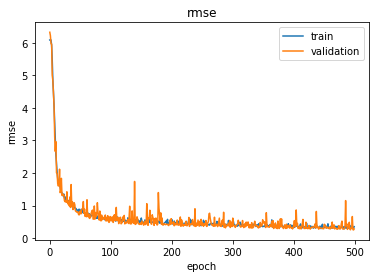

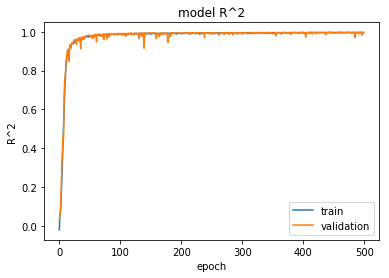

Mean absolute error (MAE):      0.278521
Mean squared error (MSE):       0.213525
Root mean squared error (RMSE): 0.462087
R square (R^2):                 0.997808


In [14]:
# Build with 60000 samples
model6, MAE6, MSE6, RMSE6, R_2_6 = model(df, 60000, 500)

In [26]:
model6.save('model60000.h5')

## Build model with 70000 samples

Train on 56000 samples, validate on 14000 samples
Epoch 1/500
56000/56000 [==============================] - 1s 13us/step - loss: 95.2159 - rmse: 6.0214 - r_square: -0.0038 - val_loss: 94.4728 - val_rmse: 6.1805 - val_r_square: 0.0456
Epoch 2/500
56000/56000 [==============================] - 0s 6us/step - loss: 88.6110 - rmse: 6.0373 - r_square: 0.0621 - val_loss: 91.2791 - val_rmse: 6.2963 - val_r_square: 0.0746
Epoch 3/500
56000/56000 [==============================] - 0s 6us/step - loss: 83.3279 - rmse: 5.9398 - r_square: 0.1160 - val_loss: 82.5399 - val_rmse: 6.0990 - val_r_square: 0.1560
Epoch 4/500
56000/56000 [==============================] - 0s 6us/step - loss: 73.8701 - rmse: 5.5967 - r_square: 0.2095 - val_loss: 72.1617 - val_rmse: 5.5625 - val_r_square: 0.2564
Epoch 5/500
56000/56000 [==============================] - 0s 5us/step - loss: 64.8579 - rmse: 5.1249 - r_square: 0.3030 - val_loss: 62.4936 - val_rmse: 4.9564 - val_r_square: 0.3528
Epoch 6/500
56000/56000 [========

56000/56000 [==============================] - 0s 5us/step - loss: 1.9445 - rmse: 0.8062 - r_square: 0.9788 - val_loss: 2.1839 - val_rmse: 0.8714 - val_r_square: 0.9773
Epoch 46/500
56000/56000 [==============================] - 0s 5us/step - loss: 1.8503 - rmse: 0.7951 - r_square: 0.9797 - val_loss: 3.0880 - val_rmse: 0.9423 - val_r_square: 0.9682
Epoch 47/500
56000/56000 [==============================] - 0s 5us/step - loss: 2.1786 - rmse: 0.8489 - r_square: 0.9764 - val_loss: 1.9169 - val_rmse: 0.8436 - val_r_square: 0.9798
Epoch 48/500
56000/56000 [==============================] - 0s 6us/step - loss: 1.7934 - rmse: 0.7821 - r_square: 0.9803 - val_loss: 1.5357 - val_rmse: 0.7277 - val_r_square: 0.9840
Epoch 49/500
56000/56000 [==============================] - 0s 5us/step - loss: 1.7075 - rmse: 0.7628 - r_square: 0.9815 - val_loss: 1.6301 - val_rmse: 0.7713 - val_r_square: 0.9829
Epoch 50/500
56000/56000 [==============================] - 0s 5us/step - loss: 1.9921 - rmse: 0.8181 -

56000/56000 [==============================] - 0s 5us/step - loss: 2.6178 - rmse: 0.8763 - r_square: 0.9713 - val_loss: 0.8558 - val_rmse: 0.5337 - val_r_square: 0.9911
Epoch 91/500
56000/56000 [==============================] - 0s 5us/step - loss: 1.1294 - rmse: 0.6074 - r_square: 0.9876 - val_loss: 0.9382 - val_rmse: 0.5927 - val_r_square: 0.9901
Epoch 92/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.9719 - rmse: 0.5714 - r_square: 0.9892 - val_loss: 1.1946 - val_rmse: 0.5843 - val_r_square: 0.9875
Epoch 93/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.9306 - rmse: 0.5629 - r_square: 0.9898 - val_loss: 0.7901 - val_rmse: 0.5195 - val_r_square: 0.9917
Epoch 94/500
56000/56000 [==============================] - 0s 6us/step - loss: 1.1186 - rmse: 0.6116 - r_square: 0.9875 - val_loss: 0.7905 - val_rmse: 0.5117 - val_r_square: 0.9917
Epoch 95/500
56000/56000 [==============================] - 0s 6us/step - loss: 1.2483 - rmse: 0.6398 -

Epoch 135/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.8074 - rmse: 0.5220 - r_square: 0.9911 - val_loss: 0.6742 - val_rmse: 0.5059 - val_r_square: 0.9929
Epoch 136/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.9769 - rmse: 0.5652 - r_square: 0.9893 - val_loss: 0.8191 - val_rmse: 0.5485 - val_r_square: 0.9913
Epoch 137/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.9122 - rmse: 0.5488 - r_square: 0.9900 - val_loss: 1.0639 - val_rmse: 0.5464 - val_r_square: 0.9889
Epoch 138/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.7340 - rmse: 0.5052 - r_square: 0.9919 - val_loss: 0.8960 - val_rmse: 0.5095 - val_r_square: 0.9907
Epoch 139/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.8396 - rmse: 0.5351 - r_square: 0.9907 - val_loss: 1.0313 - val_rmse: 0.5901 - val_r_square: 0.9891
Epoch 140/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.77

Epoch 180/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.7504 - rmse: 0.5085 - r_square: 0.9918 - val_loss: 0.5549 - val_rmse: 0.4362 - val_r_square: 0.9941
Epoch 181/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.8990 - rmse: 0.5251 - r_square: 0.9901 - val_loss: 0.7805 - val_rmse: 0.4738 - val_r_square: 0.9918
Epoch 182/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.6739 - rmse: 0.4825 - r_square: 0.9926 - val_loss: 0.5064 - val_rmse: 0.4171 - val_r_square: 0.9946
Epoch 183/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.8606 - rmse: 0.5281 - r_square: 0.9905 - val_loss: 0.5016 - val_rmse: 0.4356 - val_r_square: 0.9946
Epoch 184/500
56000/56000 [==============================] - 0s 6us/step - loss: 0.7450 - rmse: 0.4988 - r_square: 0.9918 - val_loss: 1.9737 - val_rmse: 0.7520 - val_r_square: 0.9797
Epoch 185/500
56000/56000 [==============================] - 0s 6us/step - loss: 0.72

Epoch 225/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.6372 - rmse: 0.4684 - r_square: 0.9930 - val_loss: 0.5139 - val_rmse: 0.4496 - val_r_square: 0.9945
Epoch 226/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.6653 - rmse: 0.4668 - r_square: 0.9927 - val_loss: 0.7161 - val_rmse: 0.5728 - val_r_square: 0.9924
Epoch 227/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.7554 - rmse: 0.4907 - r_square: 0.9917 - val_loss: 0.7642 - val_rmse: 0.5102 - val_r_square: 0.9919
Epoch 228/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.6650 - rmse: 0.4783 - r_square: 0.9927 - val_loss: 0.8855 - val_rmse: 0.6948 - val_r_square: 0.9906
Epoch 229/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.7739 - rmse: 0.5066 - r_square: 0.9916 - val_loss: 0.4942 - val_rmse: 0.4131 - val_r_square: 0.9947
Epoch 230/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.52

Epoch 270/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.5125 - rmse: 0.4251 - r_square: 0.9944 - val_loss: 0.3975 - val_rmse: 0.4241 - val_r_square: 0.9957
Epoch 271/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.4722 - rmse: 0.4057 - r_square: 0.9947 - val_loss: 0.3957 - val_rmse: 0.3835 - val_r_square: 0.9957
Epoch 272/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.5636 - rmse: 0.4331 - r_square: 0.9938 - val_loss: 0.5821 - val_rmse: 0.4630 - val_r_square: 0.9937
Epoch 273/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.5140 - rmse: 0.4209 - r_square: 0.9944 - val_loss: 0.4170 - val_rmse: 0.3722 - val_r_square: 0.9955
Epoch 274/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.6011 - rmse: 0.4505 - r_square: 0.9933 - val_loss: 0.5220 - val_rmse: 0.4427 - val_r_square: 0.9944
Epoch 275/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.51

Epoch 315/500
56000/56000 [==============================] - 0s 6us/step - loss: 0.5380 - rmse: 0.4292 - r_square: 0.9941 - val_loss: 0.4316 - val_rmse: 0.4326 - val_r_square: 0.9954
Epoch 316/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.5136 - rmse: 0.4197 - r_square: 0.9943 - val_loss: 0.3872 - val_rmse: 0.3788 - val_r_square: 0.9959
Epoch 317/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.5845 - rmse: 0.4364 - r_square: 0.9936 - val_loss: 0.6796 - val_rmse: 0.5708 - val_r_square: 0.9928
Epoch 318/500
56000/56000 [==============================] - 0s 6us/step - loss: 0.6679 - rmse: 0.4625 - r_square: 0.9928 - val_loss: 0.6878 - val_rmse: 0.4640 - val_r_square: 0.9928
Epoch 319/500
56000/56000 [==============================] - 0s 6us/step - loss: 0.4002 - rmse: 0.3734 - r_square: 0.9956 - val_loss: 0.3350 - val_rmse: 0.3347 - val_r_square: 0.9964
Epoch 320/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.82

Epoch 360/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3764 - rmse: 0.3589 - r_square: 0.9958 - val_loss: 0.3123 - val_rmse: 0.3276 - val_r_square: 0.9967
Epoch 361/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.6000 - rmse: 0.4365 - r_square: 0.9935 - val_loss: 0.3852 - val_rmse: 0.3917 - val_r_square: 0.9959
Epoch 362/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3786 - rmse: 0.3616 - r_square: 0.9958 - val_loss: 0.4956 - val_rmse: 0.3901 - val_r_square: 0.9948
Epoch 363/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.4878 - rmse: 0.4044 - r_square: 0.9946 - val_loss: 0.3959 - val_rmse: 0.3558 - val_r_square: 0.9958
Epoch 364/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.4293 - rmse: 0.3792 - r_square: 0.9953 - val_loss: 0.6179 - val_rmse: 0.4873 - val_r_square: 0.9936
Epoch 365/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.40

Epoch 405/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.8689 - rmse: 0.5079 - r_square: 0.9906 - val_loss: 0.5704 - val_rmse: 0.4652 - val_r_square: 0.9939
Epoch 406/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.4499 - rmse: 0.3803 - r_square: 0.9952 - val_loss: 0.7093 - val_rmse: 0.4681 - val_r_square: 0.9926
Epoch 407/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3510 - rmse: 0.3484 - r_square: 0.9962 - val_loss: 0.4275 - val_rmse: 0.3756 - val_r_square: 0.9955
Epoch 408/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3348 - rmse: 0.3359 - r_square: 0.9963 - val_loss: 0.3307 - val_rmse: 0.3477 - val_r_square: 0.9965
Epoch 409/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3705 - rmse: 0.3553 - r_square: 0.9959 - val_loss: 0.3400 - val_rmse: 0.3249 - val_r_square: 0.9964
Epoch 410/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.57

Epoch 450/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3273 - rmse: 0.3337 - r_square: 0.9964 - val_loss: 0.3514 - val_rmse: 0.3413 - val_r_square: 0.9963
Epoch 451/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3324 - rmse: 0.3397 - r_square: 0.9963 - val_loss: 0.3332 - val_rmse: 0.3269 - val_r_square: 0.9965
Epoch 452/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.4281 - rmse: 0.3772 - r_square: 0.9953 - val_loss: 0.2729 - val_rmse: 0.3177 - val_r_square: 0.9971
Epoch 453/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3938 - rmse: 0.3625 - r_square: 0.9957 - val_loss: 0.5677 - val_rmse: 0.3972 - val_r_square: 0.9942
Epoch 454/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.4950 - rmse: 0.3921 - r_square: 0.9946 - val_loss: 0.4064 - val_rmse: 0.3599 - val_r_square: 0.9957
Epoch 455/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.38

Epoch 495/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3945 - rmse: 0.3557 - r_square: 0.9957 - val_loss: 0.5514 - val_rmse: 0.4275 - val_r_square: 0.9943
Epoch 496/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.4016 - rmse: 0.3655 - r_square: 0.9955 - val_loss: 1.0600 - val_rmse: 0.5501 - val_r_square: 0.9891
Epoch 497/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.3337 - rmse: 0.3272 - r_square: 0.9964 - val_loss: 0.2326 - val_rmse: 0.2772 - val_r_square: 0.9975
Epoch 498/500
56000/56000 [==============================] - 0s 5us/step - loss: 0.5424 - rmse: 0.4077 - r_square: 0.9941 - val_loss: 0.3424 - val_rmse: 0.3125 - val_r_square: 0.9964
Epoch 499/500
56000/56000 [==============================] - 0s 6us/step - loss: 0.3797 - rmse: 0.3534 - r_square: 0.9958 - val_loss: 0.3624 - val_rmse: 0.3271 - val_r_square: 0.9962
Epoch 500/500
56000/56000 [==============================] - 0s 6us/step - loss: 0.41

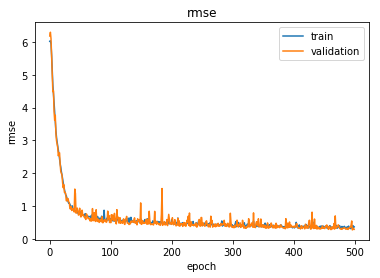

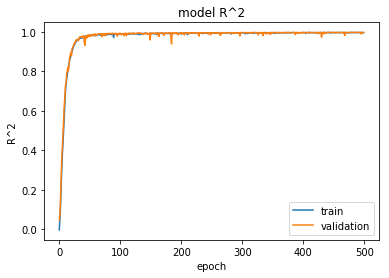

Mean absolute error (MAE):      0.293638
Mean squared error (MSE):       0.270940
Root mean squared error (RMSE): 0.520519
R square (R^2):                 0.997274


In [15]:
# Build with 70000 samples
model7, MAE7, MSE7, RMSE7, R_2_7 = model(df, 70000, 500)
model7.save('model70000.h5')

## Build model with 80000 samples

Train on 64000 samples, validate on 16000 samples
Epoch 1/500
64000/64000 [==============================] - 1s 13us/step - loss: 95.8917 - rmse: 6.0866 - r_square: 0.0019 - val_loss: 91.6873 - val_rmse: 6.2709 - val_r_square: 0.0523
Epoch 2/500
64000/64000 [==============================] - 0s 6us/step - loss: 89.7915 - rmse: 6.0830 - r_square: 0.0667 - val_loss: 88.4688 - val_rmse: 6.5817 - val_r_square: 0.0786
Epoch 3/500
64000/64000 [==============================] - 0s 6us/step - loss: 80.9516 - rmse: 5.8281 - r_square: 0.1528 - val_loss: 73.8520 - val_rmse: 5.5036 - val_r_square: 0.2284
Epoch 4/500
64000/64000 [==============================] - 0s 6us/step - loss: 68.3661 - rmse: 5.1682 - r_square: 0.2787 - val_loss: 61.9121 - val_rmse: 4.7800 - val_r_square: 0.3504
Epoch 5/500
64000/64000 [==============================] - 0s 6us/step - loss: 59.0225 - rmse: 4.6169 - r_square: 0.3750 - val_loss: 52.8275 - val_rmse: 4.1740 - val_r_square: 0.4465
Epoch 6/500
64000/64000 [=========

Epoch 46/500
64000/64000 [==============================] - 0s 5us/step - loss: 1.2448 - rmse: 0.6403 - r_square: 0.9865 - val_loss: 1.2752 - val_rmse: 0.6628 - val_r_square: 0.9862
Epoch 47/500
64000/64000 [==============================] - 0s 5us/step - loss: 1.4354 - rmse: 0.6751 - r_square: 0.9844 - val_loss: 1.1895 - val_rmse: 0.6515 - val_r_square: 0.9871
Epoch 48/500
64000/64000 [==============================] - 0s 6us/step - loss: 1.8843 - rmse: 0.7346 - r_square: 0.9801 - val_loss: 0.9239 - val_rmse: 0.5680 - val_r_square: 0.9900
Epoch 49/500
64000/64000 [==============================] - 0s 5us/step - loss: 1.3338 - rmse: 0.6425 - r_square: 0.9859 - val_loss: 0.9567 - val_rmse: 0.5835 - val_r_square: 0.9896
Epoch 50/500
64000/64000 [==============================] - 0s 5us/step - loss: 1.2021 - rmse: 0.6236 - r_square: 0.9870 - val_loss: 0.9549 - val_rmse: 0.5594 - val_r_square: 0.9898
Epoch 51/500
64000/64000 [==============================] - 0s 5us/step - loss: 1.3042 - r

64000/64000 [==============================] - 0s 6us/step - loss: 0.7722 - rmse: 0.4867 - r_square: 0.9917 - val_loss: 0.6154 - val_rmse: 0.4577 - val_r_square: 0.9933
Epoch 92/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.6551 - rmse: 0.4591 - r_square: 0.9929 - val_loss: 0.6092 - val_rmse: 0.4391 - val_r_square: 0.9934
Epoch 93/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.6878 - rmse: 0.4706 - r_square: 0.9926 - val_loss: 0.5246 - val_rmse: 0.4127 - val_r_square: 0.9943
Epoch 94/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.7201 - rmse: 0.4804 - r_square: 0.9923 - val_loss: 0.6199 - val_rmse: 0.4373 - val_r_square: 0.9934
Epoch 95/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.9398 - rmse: 0.5260 - r_square: 0.9898 - val_loss: 1.8260 - val_rmse: 0.6991 - val_r_square: 0.9806
Epoch 96/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.7592 - rmse: 0.4877 -

Epoch 136/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.6062 - rmse: 0.4344 - r_square: 0.9935 - val_loss: 0.4147 - val_rmse: 0.3810 - val_r_square: 0.9955
Epoch 137/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.6005 - rmse: 0.4373 - r_square: 0.9935 - val_loss: 1.0636 - val_rmse: 0.6221 - val_r_square: 0.9886
Epoch 138/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.6740 - rmse: 0.4585 - r_square: 0.9928 - val_loss: 0.5535 - val_rmse: 0.4262 - val_r_square: 0.9940
Epoch 139/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.7030 - rmse: 0.4651 - r_square: 0.9923 - val_loss: 0.4982 - val_rmse: 0.4172 - val_r_square: 0.9946
Epoch 140/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.6019 - rmse: 0.4333 - r_square: 0.9933 - val_loss: 0.3929 - val_rmse: 0.3710 - val_r_square: 0.9957
Epoch 141/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.56

Epoch 181/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.4686 - rmse: 0.3903 - r_square: 0.9948 - val_loss: 0.8024 - val_rmse: 0.5216 - val_r_square: 0.9914
Epoch 182/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.7461 - rmse: 0.4599 - r_square: 0.9920 - val_loss: 0.3761 - val_rmse: 0.3613 - val_r_square: 0.9959
Epoch 183/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.4924 - rmse: 0.3951 - r_square: 0.9947 - val_loss: 0.3825 - val_rmse: 0.3511 - val_r_square: 0.9959
Epoch 184/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.5516 - rmse: 0.4185 - r_square: 0.9940 - val_loss: 0.5049 - val_rmse: 0.3723 - val_r_square: 0.9946
Epoch 185/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.4331 - rmse: 0.3766 - r_square: 0.9953 - val_loss: 0.3322 - val_rmse: 0.3426 - val_r_square: 0.9964
Epoch 186/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.51

Epoch 226/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.4690 - rmse: 0.3842 - r_square: 0.9950 - val_loss: 0.3311 - val_rmse: 0.3477 - val_r_square: 0.9964
Epoch 227/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.5128 - rmse: 0.3931 - r_square: 0.9945 - val_loss: 0.2902 - val_rmse: 0.3112 - val_r_square: 0.9968
Epoch 228/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.4071 - rmse: 0.3603 - r_square: 0.9956 - val_loss: 0.3483 - val_rmse: 0.3620 - val_r_square: 0.9962
Epoch 229/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.4367 - rmse: 0.3648 - r_square: 0.9953 - val_loss: 1.6513 - val_rmse: 0.6619 - val_r_square: 0.9823
Epoch 230/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.6167 - rmse: 0.4257 - r_square: 0.9933 - val_loss: 0.3785 - val_rmse: 0.3558 - val_r_square: 0.9959
Epoch 231/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.37

Epoch 271/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.3657 - rmse: 0.3375 - r_square: 0.9961 - val_loss: 0.2952 - val_rmse: 0.3136 - val_r_square: 0.9968
Epoch 272/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.4026 - rmse: 0.3589 - r_square: 0.9957 - val_loss: 0.3032 - val_rmse: 0.3268 - val_r_square: 0.9967
Epoch 273/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.3689 - rmse: 0.3363 - r_square: 0.9960 - val_loss: 0.2832 - val_rmse: 0.3226 - val_r_square: 0.9969
Epoch 274/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.4284 - rmse: 0.3640 - r_square: 0.9953 - val_loss: 0.2694 - val_rmse: 0.3064 - val_r_square: 0.9971
Epoch 275/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.4074 - rmse: 0.3490 - r_square: 0.9957 - val_loss: 0.3129 - val_rmse: 0.3332 - val_r_square: 0.9966
Epoch 276/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.44

Epoch 316/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.3299 - rmse: 0.3166 - r_square: 0.9964 - val_loss: 0.4076 - val_rmse: 0.3349 - val_r_square: 0.9956
Epoch 317/500
64000/64000 [==============================] - 0s 7us/step - loss: 0.2593 - rmse: 0.2875 - r_square: 0.9972 - val_loss: 0.2238 - val_rmse: 0.2816 - val_r_square: 0.9976
Epoch 318/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.3404 - rmse: 0.3158 - r_square: 0.9964 - val_loss: 0.2070 - val_rmse: 0.2529 - val_r_square: 0.9978
Epoch 319/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.3123 - rmse: 0.3106 - r_square: 0.9966 - val_loss: 0.2146 - val_rmse: 0.2614 - val_r_square: 0.9977
Epoch 320/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.4035 - rmse: 0.3489 - r_square: 0.9956 - val_loss: 0.3256 - val_rmse: 0.3099 - val_r_square: 0.9965
Epoch 321/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.28

Epoch 361/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.3026 - rmse: 0.3027 - r_square: 0.9967 - val_loss: 0.4371 - val_rmse: 0.3634 - val_r_square: 0.9953
Epoch 362/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.2382 - rmse: 0.2772 - r_square: 0.9974 - val_loss: 0.1988 - val_rmse: 0.2666 - val_r_square: 0.9978
Epoch 363/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.3929 - rmse: 0.3421 - r_square: 0.9957 - val_loss: 1.3258 - val_rmse: 0.6350 - val_r_square: 0.9856
Epoch 364/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.3870 - rmse: 0.3408 - r_square: 0.9958 - val_loss: 0.5381 - val_rmse: 0.4185 - val_r_square: 0.9942
Epoch 365/500
64000/64000 [==============================] - 0s 6us/step - loss: 0.3487 - rmse: 0.3242 - r_square: 0.9962 - val_loss: 0.2576 - val_rmse: 0.2825 - val_r_square: 0.9972
Epoch 366/500
64000/64000 [==============================] - 0s 5us/step - loss: 0.35

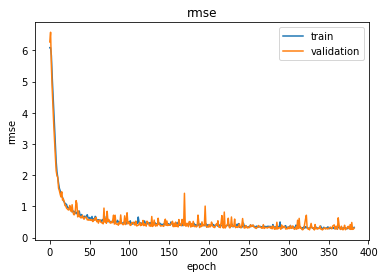

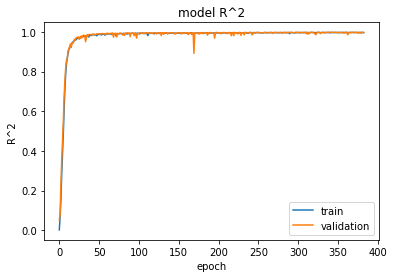

Mean absolute error (MAE):      0.305340
Mean squared error (MSE):       0.290801
Root mean squared error (RMSE): 0.539260
R square (R^2):                 0.997007


In [16]:
# Build with 80000 samples
model8, MAE8, MSE8, RMSE8, R_2_8 = model(df, 80000, 500)
model8.save('model80000.h5')

## Build model with 90000 samples

Train on 72000 samples, validate on 18000 samples
Epoch 1/500
72000/72000 [==============================] - 1s 13us/step - loss: 95.2929 - rmse: 6.0665 - r_square: 0.0043 - val_loss: 90.4899 - val_rmse: 5.9521 - val_r_square: 0.0427
Epoch 2/500
72000/72000 [==============================] - 0s 6us/step - loss: 89.4016 - rmse: 6.0764 - r_square: 0.0631 - val_loss: 86.1892 - val_rmse: 6.0471 - val_r_square: 0.0851
Epoch 3/500
72000/72000 [==============================] - 0s 6us/step - loss: 81.7298 - rmse: 5.8902 - r_square: 0.1389 - val_loss: 76.1336 - val_rmse: 5.9825 - val_r_square: 0.1814
Epoch 4/500
72000/72000 [==============================] - 0s 6us/step - loss: 71.0386 - rmse: 5.4913 - r_square: 0.2462 - val_loss: 63.7062 - val_rmse: 5.1060 - val_r_square: 0.3157
Epoch 5/500
72000/72000 [==============================] - 0s 6us/step - loss: 58.5562 - rmse: 4.8097 - r_square: 0.3779 - val_loss: 48.1434 - val_rmse: 4.2852 - val_r_square: 0.4792
Epoch 6/500
72000/72000 [=========

Epoch 46/500
72000/72000 [==============================] - 0s 6us/step - loss: 1.9953 - rmse: 0.7199 - r_square: 0.9786 - val_loss: 1.1003 - val_rmse: 0.5715 - val_r_square: 0.9880
Epoch 47/500
72000/72000 [==============================] - 0s 5us/step - loss: 1.3387 - rmse: 0.6354 - r_square: 0.9852 - val_loss: 1.1807 - val_rmse: 0.6012 - val_r_square: 0.9871
Epoch 48/500
72000/72000 [==============================] - 0s 6us/step - loss: 1.2865 - rmse: 0.6263 - r_square: 0.9862 - val_loss: 1.4010 - val_rmse: 0.6404 - val_r_square: 0.9846
Epoch 49/500
72000/72000 [==============================] - 0s 6us/step - loss: 1.1723 - rmse: 0.5974 - r_square: 0.9873 - val_loss: 1.4177 - val_rmse: 0.7339 - val_r_square: 0.9844
Epoch 50/500
72000/72000 [==============================] - 0s 6us/step - loss: 1.1254 - rmse: 0.5938 - r_square: 0.9878 - val_loss: 1.2303 - val_rmse: 0.6364 - val_r_square: 0.9866
Epoch 51/500
72000/72000 [==============================] - 0s 6us/step - loss: 1.1032 - r

72000/72000 [==============================] - 0s 6us/step - loss: 1.0644 - rmse: 0.5298 - r_square: 0.9888 - val_loss: 2.2073 - val_rmse: 0.7290 - val_r_square: 0.9758
Epoch 92/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.7795 - rmse: 0.4845 - r_square: 0.9915 - val_loss: 0.7304 - val_rmse: 0.4868 - val_r_square: 0.9920
Epoch 93/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.7596 - rmse: 0.4854 - r_square: 0.9918 - val_loss: 1.1127 - val_rmse: 0.5760 - val_r_square: 0.9878
Epoch 94/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.8261 - rmse: 0.4901 - r_square: 0.9912 - val_loss: 0.5598 - val_rmse: 0.4496 - val_r_square: 0.9938
Epoch 95/500
72000/72000 [==============================] - 0s 7us/step - loss: 0.6898 - rmse: 0.4607 - r_square: 0.9926 - val_loss: 0.4978 - val_rmse: 0.3988 - val_r_square: 0.9945
Epoch 96/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.6954 - rmse: 0.4628 -

Epoch 136/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.6090 - rmse: 0.4335 - r_square: 0.9934 - val_loss: 0.4055 - val_rmse: 0.3678 - val_r_square: 0.9955
Epoch 137/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.5292 - rmse: 0.4111 - r_square: 0.9942 - val_loss: 0.5774 - val_rmse: 0.4086 - val_r_square: 0.9937
Epoch 138/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.5625 - rmse: 0.4168 - r_square: 0.9939 - val_loss: 0.5521 - val_rmse: 0.4199 - val_r_square: 0.9940
Epoch 139/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.7426 - rmse: 0.4748 - r_square: 0.9918 - val_loss: 0.5128 - val_rmse: 0.3997 - val_r_square: 0.9944
Epoch 140/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.5266 - rmse: 0.4079 - r_square: 0.9942 - val_loss: 0.4258 - val_rmse: 0.3707 - val_r_square: 0.9953
Epoch 141/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.68

Epoch 181/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.5659 - rmse: 0.4191 - r_square: 0.9938 - val_loss: 0.3805 - val_rmse: 0.3502 - val_r_square: 0.9958
Epoch 182/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.6219 - rmse: 0.4294 - r_square: 0.9932 - val_loss: 0.4238 - val_rmse: 0.3936 - val_r_square: 0.9953
Epoch 183/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.5475 - rmse: 0.4048 - r_square: 0.9940 - val_loss: 0.7287 - val_rmse: 0.4517 - val_r_square: 0.9920
Epoch 184/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.5125 - rmse: 0.3971 - r_square: 0.9944 - val_loss: 0.4705 - val_rmse: 0.4231 - val_r_square: 0.9948
Epoch 185/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.5922 - rmse: 0.4182 - r_square: 0.9936 - val_loss: 0.3944 - val_rmse: 0.3589 - val_r_square: 0.9957
Epoch 186/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.48

Epoch 226/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.5494 - rmse: 0.4079 - r_square: 0.9940 - val_loss: 0.3296 - val_rmse: 0.3533 - val_r_square: 0.9964
Epoch 227/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.4207 - rmse: 0.3606 - r_square: 0.9954 - val_loss: 0.2948 - val_rmse: 0.3155 - val_r_square: 0.9967
Epoch 228/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.4648 - rmse: 0.3735 - r_square: 0.9950 - val_loss: 3.0189 - val_rmse: 0.8101 - val_r_square: 0.9677
Epoch 229/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.6266 - rmse: 0.4171 - r_square: 0.9933 - val_loss: 0.4279 - val_rmse: 0.3872 - val_r_square: 0.9953
Epoch 230/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.4813 - rmse: 0.3846 - r_square: 0.9947 - val_loss: 0.5703 - val_rmse: 0.4339 - val_r_square: 0.9938
Epoch 231/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.58

Epoch 271/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.5817 - rmse: 0.4095 - r_square: 0.9938 - val_loss: 0.6647 - val_rmse: 0.4685 - val_r_square: 0.9928
Epoch 272/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3207 - rmse: 0.3237 - r_square: 0.9965 - val_loss: 0.2865 - val_rmse: 0.3013 - val_r_square: 0.9968
Epoch 273/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3447 - rmse: 0.3336 - r_square: 0.9962 - val_loss: 0.3036 - val_rmse: 0.3329 - val_r_square: 0.9967
Epoch 274/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.4002 - rmse: 0.3508 - r_square: 0.9957 - val_loss: 0.3037 - val_rmse: 0.3314 - val_r_square: 0.9966
Epoch 275/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3851 - rmse: 0.3457 - r_square: 0.9958 - val_loss: 0.3109 - val_rmse: 0.3199 - val_r_square: 0.9966
Epoch 276/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.45

Epoch 316/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.4068 - rmse: 0.3490 - r_square: 0.9956 - val_loss: 0.3109 - val_rmse: 0.3172 - val_r_square: 0.9966
Epoch 317/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3048 - rmse: 0.3069 - r_square: 0.9967 - val_loss: 0.2388 - val_rmse: 0.2857 - val_r_square: 0.9974
Epoch 318/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3239 - rmse: 0.3203 - r_square: 0.9965 - val_loss: 0.3300 - val_rmse: 0.3237 - val_r_square: 0.9964
Epoch 319/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3443 - rmse: 0.3236 - r_square: 0.9963 - val_loss: 0.2616 - val_rmse: 0.2951 - val_r_square: 0.9971
Epoch 320/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3199 - rmse: 0.3185 - r_square: 0.9965 - val_loss: 0.3308 - val_rmse: 0.3591 - val_r_square: 0.9964
Epoch 321/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.32

Epoch 361/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.4038 - rmse: 0.3348 - r_square: 0.9956 - val_loss: 1.9416 - val_rmse: 0.7332 - val_r_square: 0.9792
Epoch 362/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3471 - rmse: 0.3152 - r_square: 0.9962 - val_loss: 0.2209 - val_rmse: 0.2827 - val_r_square: 0.9976
Epoch 363/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2594 - rmse: 0.2903 - r_square: 0.9972 - val_loss: 0.3104 - val_rmse: 0.2977 - val_r_square: 0.9966
Epoch 364/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2965 - rmse: 0.3026 - r_square: 0.9968 - val_loss: 0.4817 - val_rmse: 0.4008 - val_r_square: 0.9947
Epoch 365/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.4013 - rmse: 0.3420 - r_square: 0.9956 - val_loss: 0.2135 - val_rmse: 0.2680 - val_r_square: 0.9976
Epoch 366/500
72000/72000 [==============================] - 0s 5us/step - loss: 0.27

Epoch 406/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2809 - rmse: 0.2929 - r_square: 0.9970 - val_loss: 0.2704 - val_rmse: 0.2762 - val_r_square: 0.9970
Epoch 407/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3148 - rmse: 0.3045 - r_square: 0.9966 - val_loss: 0.1856 - val_rmse: 0.2482 - val_r_square: 0.9980
Epoch 408/500
72000/72000 [==============================] - 0s 5us/step - loss: 0.2861 - rmse: 0.2947 - r_square: 0.9969 - val_loss: 0.2197 - val_rmse: 0.2677 - val_r_square: 0.9976
Epoch 409/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2509 - rmse: 0.2806 - r_square: 0.9973 - val_loss: 0.3160 - val_rmse: 0.2911 - val_r_square: 0.9965
Epoch 410/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.3056 - rmse: 0.3054 - r_square: 0.9967 - val_loss: 0.2453 - val_rmse: 0.2907 - val_r_square: 0.9973
Epoch 411/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.30

Epoch 451/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2568 - rmse: 0.2782 - r_square: 0.9972 - val_loss: 1.0670 - val_rmse: 0.5476 - val_r_square: 0.9884
Epoch 452/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2677 - rmse: 0.2899 - r_square: 0.9971 - val_loss: 0.2003 - val_rmse: 0.2576 - val_r_square: 0.9978
Epoch 453/500
72000/72000 [==============================] - 0s 5us/step - loss: 0.2386 - rmse: 0.2735 - r_square: 0.9974 - val_loss: 0.2635 - val_rmse: 0.2850 - val_r_square: 0.9971
Epoch 454/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2366 - rmse: 0.2719 - r_square: 0.9974 - val_loss: 0.2781 - val_rmse: 0.3226 - val_r_square: 0.9969
Epoch 455/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2556 - rmse: 0.2824 - r_square: 0.9972 - val_loss: 0.3273 - val_rmse: 0.3020 - val_r_square: 0.9964
Epoch 456/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.32

Epoch 496/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2452 - rmse: 0.2745 - r_square: 0.9973 - val_loss: 0.3674 - val_rmse: 0.3874 - val_r_square: 0.9960
Epoch 497/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2484 - rmse: 0.2778 - r_square: 0.9973 - val_loss: 0.6406 - val_rmse: 0.3949 - val_r_square: 0.9931
Epoch 498/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2159 - rmse: 0.2608 - r_square: 0.9977 - val_loss: 0.4982 - val_rmse: 0.3444 - val_r_square: 0.9946
Epoch 499/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2601 - rmse: 0.2818 - r_square: 0.9972 - val_loss: 0.2261 - val_rmse: 0.2799 - val_r_square: 0.9975
Epoch 500/500
72000/72000 [==============================] - 0s 6us/step - loss: 0.2841 - rmse: 0.2903 - r_square: 0.9969 - val_loss: 0.1709 - val_rmse: 0.2389 - val_r_square: 0.9981


Model prediction: [[11.533912  ]
 [ 0.09786098]
 [ 0.14553635]
 [56.333527  ]
 [ 8.

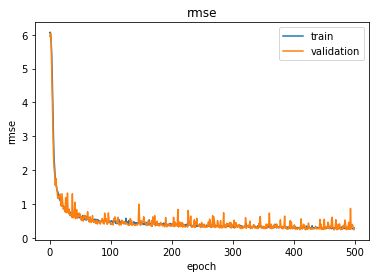

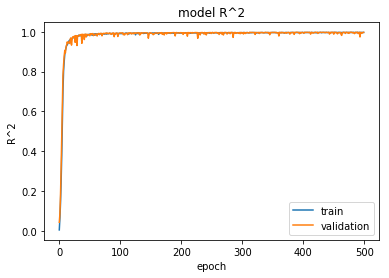

Mean absolute error (MAE):      0.238885
Mean squared error (MSE):       0.170947
Root mean squared error (RMSE): 0.413457
R square (R^2):                 0.998197


In [20]:
# Build with 90000 samples
model9, MAE9, MSE9, RMSE9, R_2_9 = model(df, 90000, 500)
model9.save('model90000.h5')

## Build model with 100000 samples

Train on 80000 samples, validate on 20000 samples
Epoch 1/500
80000/80000 [==============================] - 1s 13us/step - loss: 94.6216 - rmse: 6.1063 - r_square: 0.0142 - val_loss: 90.6205 - val_rmse: 6.0979 - val_r_square: 0.0488
Epoch 2/500
80000/80000 [==============================] - 1s 6us/step - loss: 87.5582 - rmse: 6.0725 - r_square: 0.0844 - val_loss: 83.3738 - val_rmse: 5.5975 - val_r_square: 0.1231
Epoch 3/500
80000/80000 [==============================] - 0s 6us/step - loss: 72.8368 - rmse: 5.5141 - r_square: 0.2308 - val_loss: 63.3508 - val_rmse: 4.9512 - val_r_square: 0.3260
Epoch 4/500
80000/80000 [==============================] - 0s 6us/step - loss: 59.1509 - rmse: 4.7342 - r_square: 0.3739 - val_loss: 52.0382 - val_rmse: 4.3476 - val_r_square: 0.4439
Epoch 5/500
80000/80000 [==============================] - 1s 6us/step - loss: 48.2408 - rmse: 4.1757 - r_square: 0.4816 - val_loss: 39.1623 - val_rmse: 3.8548 - val_r_square: 0.5755
Epoch 6/500
80000/80000 [=========

Epoch 46/500
80000/80000 [==============================] - 0s 6us/step - loss: 1.2765 - rmse: 0.6541 - r_square: 0.9863 - val_loss: 0.9158 - val_rmse: 0.5749 - val_r_square: 0.9900
Epoch 47/500
80000/80000 [==============================] - 0s 6us/step - loss: 1.5886 - rmse: 0.7250 - r_square: 0.9829 - val_loss: 1.4086 - val_rmse: 0.6291 - val_r_square: 0.9848
Epoch 48/500
80000/80000 [==============================] - 0s 6us/step - loss: 1.4730 - rmse: 0.6999 - r_square: 0.9842 - val_loss: 1.1165 - val_rmse: 0.6396 - val_r_square: 0.9878
Epoch 49/500
80000/80000 [==============================] - 0s 6us/step - loss: 1.2276 - rmse: 0.6446 - r_square: 0.9868 - val_loss: 1.5996 - val_rmse: 0.6941 - val_r_square: 0.9828
Epoch 50/500
80000/80000 [==============================] - 0s 6us/step - loss: 1.6709 - rmse: 0.7106 - r_square: 0.9819 - val_loss: 1.3562 - val_rmse: 0.7604 - val_r_square: 0.9852
Epoch 51/500
80000/80000 [==============================] - 0s 6us/step - loss: 1.0060 - r

80000/80000 [==============================] - 0s 6us/step - loss: 0.7738 - rmse: 0.5083 - r_square: 0.9916 - val_loss: 1.1964 - val_rmse: 0.6678 - val_r_square: 0.9870
Epoch 92/500
80000/80000 [==============================] - 0s 6us/step - loss: 1.0369 - rmse: 0.5638 - r_square: 0.9888 - val_loss: 0.6599 - val_rmse: 0.5243 - val_r_square: 0.9928
Epoch 93/500
80000/80000 [==============================] - 0s 6us/step - loss: 1.0236 - rmse: 0.5452 - r_square: 0.9890 - val_loss: 1.0493 - val_rmse: 0.6847 - val_r_square: 0.9886
Epoch 94/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.6931 - rmse: 0.4859 - r_square: 0.9924 - val_loss: 0.7953 - val_rmse: 0.5123 - val_r_square: 0.9914
Epoch 95/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.8341 - rmse: 0.5221 - r_square: 0.9910 - val_loss: 0.8377 - val_rmse: 0.5258 - val_r_square: 0.9909
Epoch 96/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.7119 - rmse: 0.4906 -

Epoch 136/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.7286 - rmse: 0.4790 - r_square: 0.9923 - val_loss: 1.3441 - val_rmse: 0.6483 - val_r_square: 0.9855
Epoch 137/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.5564 - rmse: 0.4394 - r_square: 0.9940 - val_loss: 0.9512 - val_rmse: 0.5252 - val_r_square: 0.9897
Epoch 138/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.6764 - rmse: 0.4757 - r_square: 0.9927 - val_loss: 0.6164 - val_rmse: 0.4918 - val_r_square: 0.9933
Epoch 139/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.6271 - rmse: 0.4542 - r_square: 0.9933 - val_loss: 0.4048 - val_rmse: 0.3741 - val_r_square: 0.9956
Epoch 140/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.6744 - rmse: 0.4690 - r_square: 0.9927 - val_loss: 0.4920 - val_rmse: 0.4301 - val_r_square: 0.9946
Epoch 141/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.54

Epoch 181/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.7807 - rmse: 0.4916 - r_square: 0.9914 - val_loss: 0.3694 - val_rmse: 0.3586 - val_r_square: 0.9959
Epoch 182/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.6170 - rmse: 0.4473 - r_square: 0.9934 - val_loss: 0.5348 - val_rmse: 0.4169 - val_r_square: 0.9942
Epoch 183/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.5110 - rmse: 0.4105 - r_square: 0.9944 - val_loss: 0.5064 - val_rmse: 0.4230 - val_r_square: 0.9945
Epoch 184/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.5251 - rmse: 0.4121 - r_square: 0.9943 - val_loss: 0.4391 - val_rmse: 0.3871 - val_r_square: 0.9952
Epoch 185/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.5002 - rmse: 0.4110 - r_square: 0.9946 - val_loss: 0.5619 - val_rmse: 0.4140 - val_r_square: 0.9939
Epoch 186/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.58

Epoch 226/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.4146 - rmse: 0.3740 - r_square: 0.9955 - val_loss: 0.3068 - val_rmse: 0.3276 - val_r_square: 0.9966
Epoch 227/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.4887 - rmse: 0.4028 - r_square: 0.9947 - val_loss: 0.3547 - val_rmse: 0.3477 - val_r_square: 0.9961
Epoch 228/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.4309 - rmse: 0.3768 - r_square: 0.9954 - val_loss: 0.5103 - val_rmse: 0.3893 - val_r_square: 0.9945
Epoch 229/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.4426 - rmse: 0.3794 - r_square: 0.9952 - val_loss: 0.3633 - val_rmse: 0.3727 - val_r_square: 0.9960
Epoch 230/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.4208 - rmse: 0.3788 - r_square: 0.9954 - val_loss: 0.3405 - val_rmse: 0.3602 - val_r_square: 0.9962
Epoch 231/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.52

Epoch 271/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3797 - rmse: 0.3526 - r_square: 0.9959 - val_loss: 0.3390 - val_rmse: 0.3621 - val_r_square: 0.9963
Epoch 272/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.4147 - rmse: 0.3670 - r_square: 0.9955 - val_loss: 0.4498 - val_rmse: 0.3626 - val_r_square: 0.9952
Epoch 273/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.4039 - rmse: 0.3639 - r_square: 0.9956 - val_loss: 0.2498 - val_rmse: 0.3092 - val_r_square: 0.9973
Epoch 274/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.4585 - rmse: 0.3771 - r_square: 0.9951 - val_loss: 0.3355 - val_rmse: 0.3413 - val_r_square: 0.9963
Epoch 275/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3537 - rmse: 0.3405 - r_square: 0.9962 - val_loss: 0.7717 - val_rmse: 0.4602 - val_r_square: 0.9917
Epoch 276/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.39

Epoch 316/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3645 - rmse: 0.3393 - r_square: 0.9961 - val_loss: 0.2339 - val_rmse: 0.2739 - val_r_square: 0.9974
Epoch 317/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2924 - rmse: 0.3130 - r_square: 0.9968 - val_loss: 0.2889 - val_rmse: 0.2980 - val_r_square: 0.9969
Epoch 318/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3416 - rmse: 0.3317 - r_square: 0.9963 - val_loss: 0.2477 - val_rmse: 0.2798 - val_r_square: 0.9973
Epoch 319/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.4540 - rmse: 0.3731 - r_square: 0.9951 - val_loss: 0.2957 - val_rmse: 0.3124 - val_r_square: 0.9968
Epoch 320/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3619 - rmse: 0.3442 - r_square: 0.9960 - val_loss: 0.2716 - val_rmse: 0.3190 - val_r_square: 0.9970
Epoch 321/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.29

Epoch 361/500
80000/80000 [==============================] - 1s 6us/step - loss: 0.3674 - rmse: 0.3354 - r_square: 0.9960 - val_loss: 0.2124 - val_rmse: 0.2670 - val_r_square: 0.9977
Epoch 362/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3083 - rmse: 0.3158 - r_square: 0.9966 - val_loss: 0.2282 - val_rmse: 0.2930 - val_r_square: 0.9975
Epoch 363/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2958 - rmse: 0.3087 - r_square: 0.9968 - val_loss: 0.1915 - val_rmse: 0.2504 - val_r_square: 0.9979
Epoch 364/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3979 - rmse: 0.3537 - r_square: 0.9957 - val_loss: 0.2225 - val_rmse: 0.2694 - val_r_square: 0.9976
Epoch 365/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3130 - rmse: 0.3187 - r_square: 0.9966 - val_loss: 0.2372 - val_rmse: 0.2804 - val_r_square: 0.9974
Epoch 366/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.27

Epoch 406/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2581 - rmse: 0.2898 - r_square: 0.9972 - val_loss: 0.5867 - val_rmse: 0.4427 - val_r_square: 0.9937
Epoch 407/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3085 - rmse: 0.3137 - r_square: 0.9967 - val_loss: 0.2647 - val_rmse: 0.2898 - val_r_square: 0.9971
Epoch 408/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3523 - rmse: 0.3303 - r_square: 0.9962 - val_loss: 0.2944 - val_rmse: 0.3223 - val_r_square: 0.9968
Epoch 409/500
80000/80000 [==============================] - 1s 6us/step - loss: 0.2664 - rmse: 0.2947 - r_square: 0.9971 - val_loss: 0.2214 - val_rmse: 0.2780 - val_r_square: 0.9976
Epoch 410/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3620 - rmse: 0.3293 - r_square: 0.9961 - val_loss: 0.2718 - val_rmse: 0.2869 - val_r_square: 0.9970
Epoch 411/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.31

Epoch 451/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2586 - rmse: 0.2836 - r_square: 0.9972 - val_loss: 0.6610 - val_rmse: 0.3869 - val_r_square: 0.9929
Epoch 452/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2343 - rmse: 0.2748 - r_square: 0.9975 - val_loss: 0.2906 - val_rmse: 0.3186 - val_r_square: 0.9969
Epoch 453/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2684 - rmse: 0.2961 - r_square: 0.9971 - val_loss: 0.2248 - val_rmse: 0.2674 - val_r_square: 0.9975
Epoch 454/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2832 - rmse: 0.2933 - r_square: 0.9969 - val_loss: 0.3026 - val_rmse: 0.3439 - val_r_square: 0.9967
Epoch 455/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3164 - rmse: 0.3126 - r_square: 0.9966 - val_loss: 0.2265 - val_rmse: 0.2635 - val_r_square: 0.9975
Epoch 456/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.27

Epoch 496/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.3087 - rmse: 0.3062 - r_square: 0.9966 - val_loss: 0.5893 - val_rmse: 0.3883 - val_r_square: 0.9937
Epoch 497/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2476 - rmse: 0.2795 - r_square: 0.9973 - val_loss: 0.2501 - val_rmse: 0.2603 - val_r_square: 0.9973
Epoch 498/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2672 - rmse: 0.2899 - r_square: 0.9971 - val_loss: 0.1799 - val_rmse: 0.2535 - val_r_square: 0.9980
Epoch 499/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.1905 - rmse: 0.2497 - r_square: 0.9979 - val_loss: 0.2545 - val_rmse: 0.2935 - val_r_square: 0.9972
Epoch 500/500
80000/80000 [==============================] - 0s 6us/step - loss: 0.2198 - rmse: 0.2667 - r_square: 0.9977 - val_loss: 0.2176 - val_rmse: 0.2869 - val_r_square: 0.9976


Model prediction: [[ 0.56609094]
 [ 7.2309723 ]
 [ 2.042188  ]
 [ 0.14395785]
 [ 1.

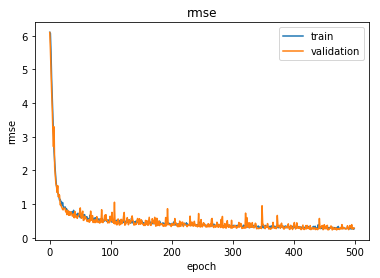

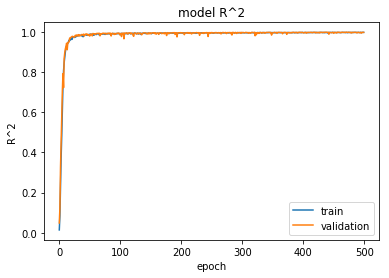

Mean absolute error (MAE):      0.286922
Mean squared error (MSE):       0.217579
Root mean squared error (RMSE): 0.466453
R square (R^2):                 0.997728


In [22]:
# Build with 100000 samples
model10, MAE10, MSE10, RMSE10, R_2_10 = model(df, 100000, 500)
model10.save('model100000.h5')

## Build model with 150000 samples

Train on 120000 samples, validate on 30000 samples
Epoch 1/500
120000/120000 [==============================] - 1s 11us/step - loss: 91.2313 - rmse: 6.0065 - r_square: 0.0359 - val_loss: 86.7089 - val_rmse: 5.9582 - val_r_square: 0.0872
Epoch 2/500
120000/120000 [==============================] - 1s 6us/step - loss: 76.5833 - rmse: 5.5969 - r_square: 0.1834 - val_loss: 64.6984 - val_rmse: 4.9392 - val_r_square: 0.3100
Epoch 3/500
120000/120000 [==============================] - 1s 7us/step - loss: 58.9131 - rmse: 4.6688 - r_square: 0.3646 - val_loss: 50.7158 - val_rmse: 4.4228 - val_r_square: 0.4531
Epoch 4/500
120000/120000 [==============================] - 1s 6us/step - loss: 43.8556 - rmse: 3.9400 - r_square: 0.5228 - val_loss: 35.3162 - val_rmse: 3.3514 - val_r_square: 0.6188
Epoch 5/500
120000/120000 [==============================] - 1s 6us/step - loss: 28.9178 - rmse: 3.1592 - r_square: 0.6839 - val_loss: 22.3354 - val_rmse: 2.8920 - val_r_square: 0.7555
Epoch 6/500
120000/1200

120000/120000 [==============================] - 1s 6us/step - loss: 1.0263 - rmse: 0.5688 - r_square: 0.9887 - val_loss: 1.6166 - val_rmse: 0.8522 - val_r_square: 0.9823
Epoch 46/500
120000/120000 [==============================] - 1s 6us/step - loss: 1.0454 - rmse: 0.5722 - r_square: 0.9885 - val_loss: 0.8359 - val_rmse: 0.5222 - val_r_square: 0.9907
Epoch 47/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.8716 - rmse: 0.5348 - r_square: 0.9904 - val_loss: 0.5680 - val_rmse: 0.4484 - val_r_square: 0.9937
Epoch 48/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.9522 - rmse: 0.5515 - r_square: 0.9894 - val_loss: 0.6479 - val_rmse: 0.4891 - val_r_square: 0.9928
Epoch 49/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.8861 - rmse: 0.5338 - r_square: 0.9902 - val_loss: 1.3190 - val_rmse: 0.5823 - val_r_square: 0.9857
Epoch 50/500
120000/120000 [==============================] - 1s 6us/step - loss: 1.0381 - rm

120000/120000 [==============================] - 1s 6us/step - loss: 0.6750 - rmse: 0.4655 - r_square: 0.9926 - val_loss: 0.4860 - val_rmse: 0.4100 - val_r_square: 0.9946
Epoch 90/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.6435 - rmse: 0.4565 - r_square: 0.9929 - val_loss: 0.5153 - val_rmse: 0.4261 - val_r_square: 0.9943
Epoch 91/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.5442 - rmse: 0.4291 - r_square: 0.9939 - val_loss: 0.4033 - val_rmse: 0.3762 - val_r_square: 0.9955
Epoch 92/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.7494 - rmse: 0.4810 - r_square: 0.9918 - val_loss: 0.4137 - val_rmse: 0.3804 - val_r_square: 0.9954
Epoch 93/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.6690 - rmse: 0.4644 - r_square: 0.9926 - val_loss: 0.3816 - val_rmse: 0.3711 - val_r_square: 0.9958
Epoch 94/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.6895 - rm

120000/120000 [==============================] - 1s 6us/step - loss: 0.6199 - rmse: 0.4328 - r_square: 0.9933 - val_loss: 0.9827 - val_rmse: 0.6550 - val_r_square: 0.9893
Epoch 134/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.5509 - rmse: 0.4212 - r_square: 0.9939 - val_loss: 0.6918 - val_rmse: 0.4619 - val_r_square: 0.9924
Epoch 135/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.6784 - rmse: 0.4474 - r_square: 0.9926 - val_loss: 1.3565 - val_rmse: 0.7234 - val_r_square: 0.9852
Epoch 136/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.6637 - rmse: 0.4385 - r_square: 0.9926 - val_loss: 0.6523 - val_rmse: 0.4361 - val_r_square: 0.9930
Epoch 137/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.5287 - rmse: 0.4046 - r_square: 0.9941 - val_loss: 0.7185 - val_rmse: 0.4683 - val_r_square: 0.9922
Epoch 138/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.5715

120000/120000 [==============================] - 1s 6us/step - loss: 0.4962 - rmse: 0.3913 - r_square: 0.9946 - val_loss: 0.2953 - val_rmse: 0.3209 - val_r_square: 0.9967
Epoch 178/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.4754 - rmse: 0.3832 - r_square: 0.9948 - val_loss: 1.0533 - val_rmse: 0.5369 - val_r_square: 0.9885
Epoch 179/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.4882 - rmse: 0.3841 - r_square: 0.9946 - val_loss: 0.5547 - val_rmse: 0.4217 - val_r_square: 0.9939
Epoch 180/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.4317 - rmse: 0.3618 - r_square: 0.9953 - val_loss: 2.6877 - val_rmse: 0.8864 - val_r_square: 0.9715
Epoch 181/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.4865 - rmse: 0.3821 - r_square: 0.9946 - val_loss: 0.2985 - val_rmse: 0.3221 - val_r_square: 0.9967
Epoch 182/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.4403

120000/120000 [==============================] - 1s 6us/step - loss: 0.3347 - rmse: 0.3292 - r_square: 0.9963 - val_loss: 0.2451 - val_rmse: 0.2785 - val_r_square: 0.9973
Epoch 222/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.4415 - rmse: 0.3587 - r_square: 0.9952 - val_loss: 0.2926 - val_rmse: 0.2928 - val_r_square: 0.9968
Epoch 223/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.3695 - rmse: 0.3419 - r_square: 0.9959 - val_loss: 0.3620 - val_rmse: 0.3164 - val_r_square: 0.9960
Epoch 224/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.3140 - rmse: 0.3186 - r_square: 0.9965 - val_loss: 0.2296 - val_rmse: 0.2765 - val_r_square: 0.9975
Epoch 225/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.4086 - rmse: 0.3514 - r_square: 0.9955 - val_loss: 0.4013 - val_rmse: 0.3754 - val_r_square: 0.9956
Epoch 226/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.3866

120000/120000 [==============================] - 1s 6us/step - loss: 0.3689 - rmse: 0.3300 - r_square: 0.9960 - val_loss: 0.2937 - val_rmse: 0.2906 - val_r_square: 0.9968
Epoch 266/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2666 - rmse: 0.2957 - r_square: 0.9970 - val_loss: 0.2565 - val_rmse: 0.2875 - val_r_square: 0.9972
Epoch 267/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2829 - rmse: 0.3015 - r_square: 0.9968 - val_loss: 0.7614 - val_rmse: 0.4404 - val_r_square: 0.9918
Epoch 268/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.3107 - rmse: 0.3141 - r_square: 0.9966 - val_loss: 0.2854 - val_rmse: 0.3098 - val_r_square: 0.9969
Epoch 269/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.3388 - rmse: 0.3241 - r_square: 0.9963 - val_loss: 0.1991 - val_rmse: 0.2632 - val_r_square: 0.9978
Epoch 270/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2798

120000/120000 [==============================] - 1s 6us/step - loss: 0.2295 - rmse: 0.2762 - r_square: 0.9975 - val_loss: 0.1797 - val_rmse: 0.2564 - val_r_square: 0.9980
Epoch 310/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.3466 - rmse: 0.3264 - r_square: 0.9962 - val_loss: 0.1545 - val_rmse: 0.2267 - val_r_square: 0.9983
Epoch 311/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2340 - rmse: 0.2741 - r_square: 0.9975 - val_loss: 0.1939 - val_rmse: 0.2672 - val_r_square: 0.9979
Epoch 312/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2587 - rmse: 0.2846 - r_square: 0.9972 - val_loss: 0.2172 - val_rmse: 0.2644 - val_r_square: 0.9976
Epoch 313/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2806 - rmse: 0.2964 - r_square: 0.9969 - val_loss: 0.9990 - val_rmse: 0.5441 - val_r_square: 0.9891
Epoch 314/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2532

120000/120000 [==============================] - 1s 6us/step - loss: 0.2223 - rmse: 0.2696 - r_square: 0.9975 - val_loss: 0.3638 - val_rmse: 0.3474 - val_r_square: 0.9960
Epoch 354/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2533 - rmse: 0.2818 - r_square: 0.9972 - val_loss: 0.1547 - val_rmse: 0.2284 - val_r_square: 0.9983
Epoch 355/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2162 - rmse: 0.2687 - r_square: 0.9976 - val_loss: 0.1699 - val_rmse: 0.2635 - val_r_square: 0.9981
Epoch 356/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2252 - rmse: 0.2698 - r_square: 0.9975 - val_loss: 0.3307 - val_rmse: 0.2971 - val_r_square: 0.9964
Epoch 357/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2400 - rmse: 0.2788 - r_square: 0.9974 - val_loss: 0.1624 - val_rmse: 0.2338 - val_r_square: 0.9982
Epoch 358/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2243

120000/120000 [==============================] - 1s 6us/step - loss: 0.2456 - rmse: 0.2777 - r_square: 0.9973 - val_loss: 0.2583 - val_rmse: 0.2694 - val_r_square: 0.9972
Epoch 398/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.3159 - rmse: 0.2986 - r_square: 0.9965 - val_loss: 0.2116 - val_rmse: 0.2453 - val_r_square: 0.9977
Epoch 399/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2184 - rmse: 0.2625 - r_square: 0.9976 - val_loss: 0.1589 - val_rmse: 0.2305 - val_r_square: 0.9982
Epoch 400/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.1877 - rmse: 0.2490 - r_square: 0.9979 - val_loss: 0.1911 - val_rmse: 0.2543 - val_r_square: 0.9979
Epoch 401/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2171 - rmse: 0.2636 - r_square: 0.9976 - val_loss: 0.1450 - val_rmse: 0.2229 - val_r_square: 0.9984
Epoch 402/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2069

120000/120000 [==============================] - 1s 6us/step - loss: 0.2192 - rmse: 0.2627 - r_square: 0.9976 - val_loss: 0.2004 - val_rmse: 0.2496 - val_r_square: 0.9978
Epoch 442/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2202 - rmse: 0.2616 - r_square: 0.9976 - val_loss: 0.2004 - val_rmse: 0.2617 - val_r_square: 0.9978
Epoch 443/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2432 - rmse: 0.2731 - r_square: 0.9973 - val_loss: 0.1633 - val_rmse: 0.2282 - val_r_square: 0.9982
Epoch 444/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2184 - rmse: 0.2633 - r_square: 0.9976 - val_loss: 0.2306 - val_rmse: 0.2663 - val_r_square: 0.9975
Epoch 445/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.2091 - rmse: 0.2578 - r_square: 0.9977 - val_loss: 0.1474 - val_rmse: 0.2195 - val_r_square: 0.9984
Epoch 446/500
120000/120000 [==============================] - 1s 6us/step - loss: 0.1788

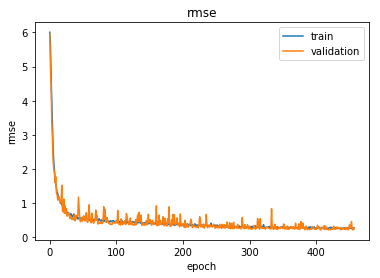

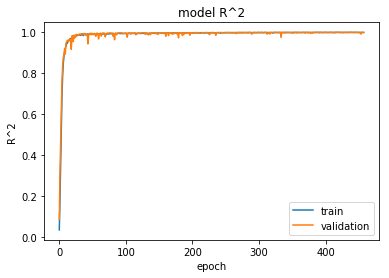

Mean absolute error (MAE):      0.267735
Mean squared error (MSE):       0.222714
Root mean squared error (RMSE): 0.471925
R square (R^2):                 0.997671


In [27]:
# Build with 150000 samples
model15, MAE15, MSE15, RMSE15, R_2_15 = model(df, 150000, 500)
model15.save('model150000.h5')

## Build model with 200000 samples

Train on 160000 samples, validate on 40000 samples
Epoch 1/500
160000/160000 [==============================] - 2s 10us/step - loss: 91.6199 - rmse: 6.0795 - r_square: 0.0477 - val_loss: 83.5557 - val_rmse: 5.9535 - val_r_square: 0.1304
Epoch 2/500
160000/160000 [==============================] - 1s 6us/step - loss: 68.8191 - rmse: 5.2596 - r_square: 0.2749 - val_loss: 56.1440 - val_rmse: 4.6524 - val_r_square: 0.4038
Epoch 3/500
160000/160000 [==============================] - 1s 6us/step - loss: 47.8147 - rmse: 4.2184 - r_square: 0.4922 - val_loss: 39.0207 - val_rmse: 3.6618 - val_r_square: 0.5859
Epoch 4/500
160000/160000 [==============================] - 1s 6us/step - loss: 27.0033 - rmse: 3.2301 - r_square: 0.7119 - val_loss: 18.7539 - val_rmse: 2.7146 - val_r_square: 0.7979
Epoch 5/500
160000/160000 [==============================] - 1s 6us/step - loss: 15.3036 - rmse: 2.3874 - r_square: 0.8358 - val_loss: 10.8653 - val_rmse: 2.0027 - val_r_square: 0.8839
Epoch 6/500
160000/1600

160000/160000 [==============================] - 1s 6us/step - loss: 0.8225 - rmse: 0.5008 - r_square: 0.9913 - val_loss: 0.6175 - val_rmse: 0.4468 - val_r_square: 0.9933
Epoch 46/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.8497 - rmse: 0.5107 - r_square: 0.9908 - val_loss: 0.5055 - val_rmse: 0.4186 - val_r_square: 0.9945
Epoch 47/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.7717 - rmse: 0.4964 - r_square: 0.9917 - val_loss: 0.7836 - val_rmse: 0.4971 - val_r_square: 0.9916
Epoch 48/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.8190 - rmse: 0.5054 - r_square: 0.9912 - val_loss: 0.4721 - val_rmse: 0.4062 - val_r_square: 0.9948
Epoch 49/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.7378 - rmse: 0.4819 - r_square: 0.9920 - val_loss: 0.6661 - val_rmse: 0.4447 - val_r_square: 0.9928
Epoch 50/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.7224 - rm

160000/160000 [==============================] - 1s 6us/step - loss: 0.5219 - rmse: 0.4098 - r_square: 0.9944 - val_loss: 0.5626 - val_rmse: 0.4181 - val_r_square: 0.9939
Epoch 90/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.6992 - rmse: 0.4544 - r_square: 0.9924 - val_loss: 1.1020 - val_rmse: 0.5574 - val_r_square: 0.9881
Epoch 91/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.5890 - rmse: 0.4274 - r_square: 0.9937 - val_loss: 0.8532 - val_rmse: 0.4758 - val_r_square: 0.9908
Epoch 92/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.5081 - rmse: 0.4031 - r_square: 0.9945 - val_loss: 0.7552 - val_rmse: 0.4846 - val_r_square: 0.9918
Epoch 93/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.4698 - rmse: 0.3932 - r_square: 0.9949 - val_loss: 0.3398 - val_rmse: 0.3518 - val_r_square: 0.9963
Epoch 94/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.5606 - rm

160000/160000 [==============================] - 1s 6us/step - loss: 0.4437 - rmse: 0.3676 - r_square: 0.9952 - val_loss: 0.3037 - val_rmse: 0.3271 - val_r_square: 0.9967
Epoch 134/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.3768 - rmse: 0.3512 - r_square: 0.9959 - val_loss: 0.2702 - val_rmse: 0.2990 - val_r_square: 0.9971
Epoch 135/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.4194 - rmse: 0.3639 - r_square: 0.9955 - val_loss: 0.3055 - val_rmse: 0.3318 - val_r_square: 0.9967
Epoch 136/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.3628 - rmse: 0.3446 - r_square: 0.9961 - val_loss: 0.2624 - val_rmse: 0.3016 - val_r_square: 0.9971
Epoch 137/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.5176 - rmse: 0.3917 - r_square: 0.9945 - val_loss: 0.3016 - val_rmse: 0.3272 - val_r_square: 0.9967
Epoch 138/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.3837

160000/160000 [==============================] - 1s 6us/step - loss: 0.3172 - rmse: 0.3154 - r_square: 0.9966 - val_loss: 0.3752 - val_rmse: 0.3447 - val_r_square: 0.9960
Epoch 178/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.3211 - rmse: 0.3188 - r_square: 0.9965 - val_loss: 0.4309 - val_rmse: 0.3277 - val_r_square: 0.9955
Epoch 179/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.3319 - rmse: 0.3254 - r_square: 0.9964 - val_loss: 0.1968 - val_rmse: 0.2613 - val_r_square: 0.9979
Epoch 180/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.3569 - rmse: 0.3290 - r_square: 0.9962 - val_loss: 0.2319 - val_rmse: 0.2748 - val_r_square: 0.9975
Epoch 181/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.3023 - rmse: 0.3117 - r_square: 0.9967 - val_loss: 0.2054 - val_rmse: 0.2723 - val_r_square: 0.9978
Epoch 182/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.3062

160000/160000 [==============================] - 1s 6us/step - loss: 0.2595 - rmse: 0.2859 - r_square: 0.9972 - val_loss: 0.1919 - val_rmse: 0.2699 - val_r_square: 0.9979
Epoch 222/500
160000/160000 [==============================] - 1s 7us/step - loss: 0.3171 - rmse: 0.3091 - r_square: 0.9966 - val_loss: 0.3442 - val_rmse: 0.3033 - val_r_square: 0.9963
Epoch 223/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2600 - rmse: 0.2818 - r_square: 0.9972 - val_loss: 0.2383 - val_rmse: 0.2897 - val_r_square: 0.9974
Epoch 224/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2642 - rmse: 0.2881 - r_square: 0.9972 - val_loss: 0.3001 - val_rmse: 0.2949 - val_r_square: 0.9968
Epoch 225/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2754 - rmse: 0.2930 - r_square: 0.9970 - val_loss: 0.1866 - val_rmse: 0.2421 - val_r_square: 0.9980
Epoch 226/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2539

160000/160000 [==============================] - 1s 6us/step - loss: 0.2503 - rmse: 0.2787 - r_square: 0.9973 - val_loss: 0.1657 - val_rmse: 0.2337 - val_r_square: 0.9982
Epoch 266/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2466 - rmse: 0.2756 - r_square: 0.9973 - val_loss: 0.4009 - val_rmse: 0.3826 - val_r_square: 0.9957
Epoch 267/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2303 - rmse: 0.2692 - r_square: 0.9975 - val_loss: 0.1548 - val_rmse: 0.2265 - val_r_square: 0.9983
Epoch 268/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2044 - rmse: 0.2549 - r_square: 0.9978 - val_loss: 0.1639 - val_rmse: 0.2364 - val_r_square: 0.9982
Epoch 269/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2328 - rmse: 0.2707 - r_square: 0.9975 - val_loss: 0.3609 - val_rmse: 0.3582 - val_r_square: 0.9961
Epoch 270/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2287

160000/160000 [==============================] - 1s 6us/step - loss: 0.2368 - rmse: 0.2699 - r_square: 0.9974 - val_loss: 0.2062 - val_rmse: 0.2501 - val_r_square: 0.9978
Epoch 310/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2371 - rmse: 0.2620 - r_square: 0.9975 - val_loss: 0.1425 - val_rmse: 0.2277 - val_r_square: 0.9985
Epoch 311/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1939 - rmse: 0.2444 - r_square: 0.9979 - val_loss: 0.1467 - val_rmse: 0.2233 - val_r_square: 0.9984
Epoch 312/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1934 - rmse: 0.2456 - r_square: 0.9979 - val_loss: 0.1244 - val_rmse: 0.2037 - val_r_square: 0.9987
Epoch 313/500
160000/160000 [==============================] - 1s 7us/step - loss: 0.2364 - rmse: 0.2678 - r_square: 0.9975 - val_loss: 0.1818 - val_rmse: 0.2288 - val_r_square: 0.9980
Epoch 314/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1711

160000/160000 [==============================] - 1s 7us/step - loss: 0.2176 - rmse: 0.2553 - r_square: 0.9977 - val_loss: 0.1607 - val_rmse: 0.2436 - val_r_square: 0.9983
Epoch 354/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1736 - rmse: 0.2312 - r_square: 0.9981 - val_loss: 0.1368 - val_rmse: 0.2219 - val_r_square: 0.9985
Epoch 355/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2146 - rmse: 0.2540 - r_square: 0.9977 - val_loss: 0.2233 - val_rmse: 0.2857 - val_r_square: 0.9976
Epoch 356/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1623 - rmse: 0.2272 - r_square: 0.9982 - val_loss: 0.2800 - val_rmse: 0.2831 - val_r_square: 0.9969
Epoch 357/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2081 - rmse: 0.2490 - r_square: 0.9978 - val_loss: 0.1358 - val_rmse: 0.2178 - val_r_square: 0.9985
Epoch 358/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1941

160000/160000 [==============================] - 1s 6us/step - loss: 0.2567 - rmse: 0.2595 - r_square: 0.9973 - val_loss: 0.1198 - val_rmse: 0.1989 - val_r_square: 0.9987
Epoch 398/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1576 - rmse: 0.2209 - r_square: 0.9983 - val_loss: 0.1144 - val_rmse: 0.1963 - val_r_square: 0.9988
Epoch 399/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1828 - rmse: 0.2361 - r_square: 0.9980 - val_loss: 0.1997 - val_rmse: 0.2543 - val_r_square: 0.9978
Epoch 400/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1642 - rmse: 0.2255 - r_square: 0.9982 - val_loss: 0.2721 - val_rmse: 0.3048 - val_r_square: 0.9971
Epoch 401/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.2102 - rmse: 0.2501 - r_square: 0.9977 - val_loss: 0.1410 - val_rmse: 0.2056 - val_r_square: 0.9985
Epoch 402/500
160000/160000 [==============================] - 1s 6us/step - loss: 0.1794

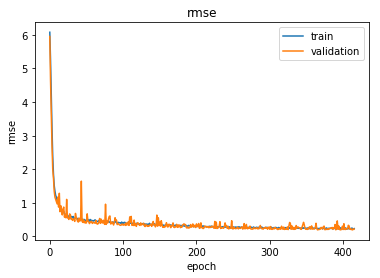

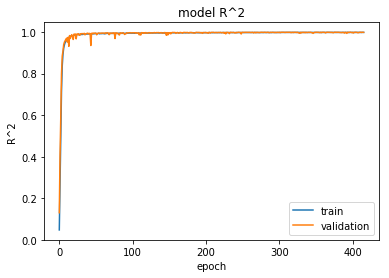

Mean absolute error (MAE):      0.216881
Mean squared error (MSE):       0.155362
Root mean squared error (RMSE): 0.394159
R square (R^2):                 0.998400


In [29]:
# Build with 200000 samples
model20, MAE20, MSE20, RMSE20, R_2_20 = model(df, 200000, 500)
model20.save('model200000.h5')

Train on 200000 samples, validate on 50000 samples
Epoch 1/500
200000/200000 [==============================] - 2s 10us/step - loss: 89.4645 - rmse: 6.0346 - r_square: 0.0756 - val_loss: 77.3756 - val_rmse: 5.4983 - val_r_square: 0.1915
Epoch 2/500
200000/200000 [==============================] - 1s 6us/step - loss: 59.6684 - rmse: 4.7316 - r_square: 0.3734 - val_loss: 46.3284 - val_rmse: 3.9608 - val_r_square: 0.5028
Epoch 3/500
200000/200000 [==============================] - 1s 6us/step - loss: 28.5203 - rmse: 3.1041 - r_square: 0.6992 - val_loss: 26.7578 - val_rmse: 2.8081 - val_r_square: 0.7196
Epoch 4/500
200000/200000 [==============================] - 1s 6us/step - loss: 12.2531 - rmse: 2.0410 - r_square: 0.8704 - val_loss: 8.5938 - val_rmse: 1.7168 - val_r_square: 0.9082
Epoch 5/500
200000/200000 [==============================] - 1s 6us/step - loss: 7.6394 - rmse: 1.5914 - r_square: 0.9187 - val_loss: 6.0842 - val_rmse: 1.4613 - val_r_square: 0.9348
Epoch 6/500
200000/200000 

200000/200000 [==============================] - 1s 6us/step - loss: 0.6839 - rmse: 0.4651 - r_square: 0.9927 - val_loss: 1.0012 - val_rmse: 0.5310 - val_r_square: 0.9892
Epoch 46/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.6378 - rmse: 0.4508 - r_square: 0.9932 - val_loss: 0.4183 - val_rmse: 0.3845 - val_r_square: 0.9955
Epoch 47/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.7036 - rmse: 0.4669 - r_square: 0.9925 - val_loss: 0.4548 - val_rmse: 0.4078 - val_r_square: 0.9951
Epoch 48/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.7282 - rmse: 0.4661 - r_square: 0.9922 - val_loss: 0.4379 - val_rmse: 0.3751 - val_r_square: 0.9953
Epoch 49/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.6408 - rmse: 0.4479 - r_square: 0.9931 - val_loss: 0.4608 - val_rmse: 0.3927 - val_r_square: 0.9950
Epoch 50/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.7464 - rm

200000/200000 [==============================] - 1s 6us/step - loss: 0.4971 - rmse: 0.3845 - r_square: 0.9946 - val_loss: 0.6602 - val_rmse: 0.4978 - val_r_square: 0.9929
Epoch 90/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.4905 - rmse: 0.3851 - r_square: 0.9947 - val_loss: 2.8102 - val_rmse: 0.8505 - val_r_square: 0.9707
Epoch 91/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.4509 - rmse: 0.3730 - r_square: 0.9952 - val_loss: 0.3834 - val_rmse: 0.3574 - val_r_square: 0.9959
Epoch 92/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.4257 - rmse: 0.3652 - r_square: 0.9954 - val_loss: 0.3075 - val_rmse: 0.3267 - val_r_square: 0.9967
Epoch 93/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.4856 - rmse: 0.3867 - r_square: 0.9948 - val_loss: 0.4938 - val_rmse: 0.4224 - val_r_square: 0.9947
Epoch 94/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.5353 - rm

200000/200000 [==============================] - 1s 6us/step - loss: 0.3085 - rmse: 0.3088 - r_square: 0.9967 - val_loss: 0.2683 - val_rmse: 0.2931 - val_r_square: 0.9971
Epoch 134/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.3717 - rmse: 0.3323 - r_square: 0.9960 - val_loss: 0.7592 - val_rmse: 0.4331 - val_r_square: 0.9919
Epoch 135/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.3903 - rmse: 0.3392 - r_square: 0.9958 - val_loss: 0.3167 - val_rmse: 0.3232 - val_r_square: 0.9966
Epoch 136/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.3594 - rmse: 0.3244 - r_square: 0.9961 - val_loss: 0.2316 - val_rmse: 0.2710 - val_r_square: 0.9975
Epoch 137/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.3071 - rmse: 0.3063 - r_square: 0.9967 - val_loss: 0.3926 - val_rmse: 0.3579 - val_r_square: 0.9957
Epoch 138/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.3258

200000/200000 [==============================] - 1s 6us/step - loss: 0.4701 - rmse: 0.3429 - r_square: 0.9949 - val_loss: 0.2582 - val_rmse: 0.2656 - val_r_square: 0.9972
Epoch 178/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2320 - rmse: 0.2690 - r_square: 0.9975 - val_loss: 0.1674 - val_rmse: 0.2514 - val_r_square: 0.9982
Epoch 179/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2362 - rmse: 0.2694 - r_square: 0.9975 - val_loss: 0.1550 - val_rmse: 0.2298 - val_r_square: 0.9983
Epoch 180/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2579 - rmse: 0.2784 - r_square: 0.9972 - val_loss: 0.2517 - val_rmse: 0.2857 - val_r_square: 0.9973
Epoch 181/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2957 - rmse: 0.2942 - r_square: 0.9968 - val_loss: 0.2458 - val_rmse: 0.2834 - val_r_square: 0.9973
Epoch 182/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2677

200000/200000 [==============================] - 1s 6us/step - loss: 0.2597 - rmse: 0.2775 - r_square: 0.9972 - val_loss: 0.1732 - val_rmse: 0.2325 - val_r_square: 0.9981
Epoch 222/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2044 - rmse: 0.2509 - r_square: 0.9978 - val_loss: 0.2292 - val_rmse: 0.2675 - val_r_square: 0.9975
Epoch 223/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2262 - rmse: 0.2626 - r_square: 0.9976 - val_loss: 0.2531 - val_rmse: 0.2982 - val_r_square: 0.9973
Epoch 224/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2228 - rmse: 0.2622 - r_square: 0.9976 - val_loss: 0.2551 - val_rmse: 0.3119 - val_r_square: 0.9972
Epoch 225/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2105 - rmse: 0.2548 - r_square: 0.9978 - val_loss: 0.4322 - val_rmse: 0.3250 - val_r_square: 0.9955
Epoch 226/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2406

200000/200000 [==============================] - 1s 6us/step - loss: 0.2424 - rmse: 0.2647 - r_square: 0.9974 - val_loss: 0.2661 - val_rmse: 0.2896 - val_r_square: 0.9971
Epoch 266/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2363 - rmse: 0.2602 - r_square: 0.9974 - val_loss: 0.1599 - val_rmse: 0.2369 - val_r_square: 0.9983
Epoch 267/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2144 - rmse: 0.2507 - r_square: 0.9977 - val_loss: 0.3810 - val_rmse: 0.3397 - val_r_square: 0.9960
Epoch 268/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2078 - rmse: 0.2495 - r_square: 0.9978 - val_loss: 0.2505 - val_rmse: 0.2520 - val_r_square: 0.9974
Epoch 269/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2190 - rmse: 0.2553 - r_square: 0.9977 - val_loss: 0.1449 - val_rmse: 0.2204 - val_r_square: 0.9984
Epoch 270/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2122

200000/200000 [==============================] - 1s 6us/step - loss: 0.1911 - rmse: 0.2409 - r_square: 0.9980 - val_loss: 0.3569 - val_rmse: 0.3026 - val_r_square: 0.9962
Epoch 310/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.1867 - rmse: 0.2359 - r_square: 0.9980 - val_loss: 0.1669 - val_rmse: 0.2438 - val_r_square: 0.9982
Epoch 311/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.1720 - rmse: 0.2310 - r_square: 0.9982 - val_loss: 0.2204 - val_rmse: 0.2401 - val_r_square: 0.9977
Epoch 312/500
200000/200000 [==============================] - 1s 7us/step - loss: 0.2119 - rmse: 0.2511 - r_square: 0.9977 - val_loss: 0.1459 - val_rmse: 0.2191 - val_r_square: 0.9984
Epoch 313/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.1668 - rmse: 0.2267 - r_square: 0.9982 - val_loss: 0.2912 - val_rmse: 0.2641 - val_r_square: 0.9969
Epoch 314/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2120

200000/200000 [==============================] - 1s 6us/step - loss: 0.2136 - rmse: 0.2419 - r_square: 0.9977 - val_loss: 0.2244 - val_rmse: 0.2575 - val_r_square: 0.9976
Epoch 354/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.2176 - rmse: 0.2458 - r_square: 0.9977 - val_loss: 0.2267 - val_rmse: 0.2827 - val_r_square: 0.9976
Epoch 355/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.1432 - rmse: 0.2129 - r_square: 0.9985 - val_loss: 0.2160 - val_rmse: 0.2423 - val_r_square: 0.9977
Epoch 356/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.1851 - rmse: 0.2343 - r_square: 0.9980 - val_loss: 0.1524 - val_rmse: 0.2254 - val_r_square: 0.9984
Epoch 357/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.1798 - rmse: 0.2329 - r_square: 0.9981 - val_loss: 0.2191 - val_rmse: 0.2914 - val_r_square: 0.9976
Epoch 358/500
200000/200000 [==============================] - 1s 6us/step - loss: 0.1581

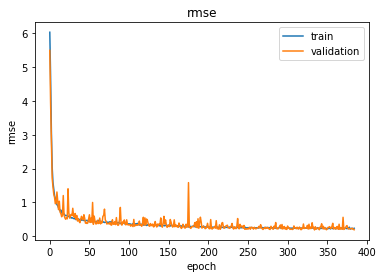

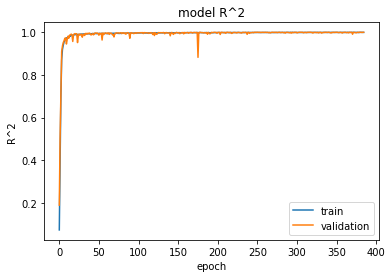

Mean absolute error (MAE):      0.189890
Mean squared error (MSE):       0.105128
Root mean squared error (RMSE): 0.324235
R square (R^2):                 0.998915


In [32]:
# Build with 200000 samples
model25, MAE25, MSE25, RMSE25, R_2_25 = model(df, 250000, 500)
model25.save('model250000.h5')

Text(0.5,0,'Sample size')

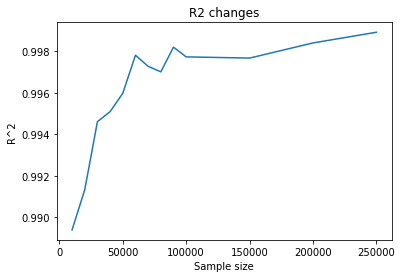

In [33]:
sample_size = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 150000, 200000, 250000]
r2 = [R_2_1, R_2_2, R_2_3, R_2_4, R_2_5, R_2_6, R_2_7, R_2_8, R_2_9, R_2_10, R_2_15, R_2_20, R_2_25]
plt.plot(sample_size, r2)
plt.title('R2 changes')
plt.ylabel('R^2')
plt.xlabel('Sample size')

## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>